# Modeling Notebook

## Libary Imports

In [1]:
## Import necessary libraries here
import os
import random
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from pathlib import Path
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline as SKPipeline
from sklearn.utils.class_weight import compute_class_weight
from matplotlib.ticker import ScalarFormatter

warnings.filterwarnings("ignore")

In [2]:
# set the random seed for reproducibility
RANDOM_SEED = 2025

# Establish output directories for images and tables developed
IMAGE_DIR = Path("../Images/")
TABLE_DIR = Path("../Tables/")

In [3]:
# create helper functions to save images and tables to respective directories
def save_figure(fig, filename: str, dpi: int = 300) -> None:
    """
    Save a matplotlib/seaborn figure to the Images directory.
    """
    filepath = IMAGE_DIR / filename
    fig.savefig(filepath, dpi=dpi, bbox_inches="tight")
    print(f"Saved figure to {filepath}")

def save_table(df, filename: str, index: bool = False) -> None:
    """
    Save a pandas or polars DataFrame to the Tables directory as CSV.
    """
    filepath = TABLE_DIR / filename

    # Handle polars vs pandas
    if isinstance(df, pl.DataFrame):
        df.write_csv(str(filepath))
    else:
        # assume pandas-like
        df.to_csv(str(filepath), index=index)

    print(f"Saved table to {filepath}")

## Data Access and Loading

In [4]:
# set the filepath to the parquet cleaned dataset
PATH = "../Data/Cleaned/Cleaned_Dataset.parquet"

# scan the parquet file with polars
scan = pl.scan_parquet(PATH)

df = scan.collect()
# drop the unneeded target columns for this 8-family analysis
df = df.drop(['Label', 'Label_Binary'])

# get schema
schema = df.schema

# cast Protocol_Type to categorical
df = df.with_columns(pl.col("Protocol_Type").cast(pl.Categorical))


In [5]:
# set feature and target variables
TARGET_FAMILY = 'Label_Family'

feature_columns = [col for col in df.columns if col != TARGET_FAMILY]

# categorical columns
CATEGORICAL_COLUMNS = ["Protocol_Type"]
# numerical columns
NUMERICAL_COLUMNS = [col for col, dtype in schema.items() if dtype in [pl.Int32, pl.Float32] and col != TARGET_FAMILY]

In [6]:
# convert to pandas for modeling
pdf = df.to_pandas()

X = pdf[feature_columns]
y = pdf[TARGET_FAMILY]

# Train / Test / Validation Split

In order to properly handle the imbalanced nature of the dataset the training data will be split and have a balanced nature to capture the minority class better. The test and validation sets will remain imbalanced to reflect real world data and to properly evaluate model performance.

In [7]:
# stratified split into train_full and temp (val+test)
X_train_full, X_temp, y_train_full, y_temp = train_test_split(
    X,
    y,
    test_size=0.30,          # 70% train, 30% temp (val+test)
    stratify=y,
    random_state=RANDOM_SEED
)

# split temp into validation and test (both still imbalanced but representative)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,          # 15% val, 15% test overall
    stratify=y_temp,
    random_state=RANDOM_SEED
)

print("Class distribution (train_full):")
print(y_train_full.value_counts(normalize=True))

print("\nClass distribution (val):")
print(y_val.value_counts(normalize=True))

print("\nClass distribution (test):")
print(y_test.value_counts(normalize=True))

Class distribution (train_full):
Label_Family
DDOS           0.585191
DOS            0.198946
MIRAI          0.112314
BENIGN         0.049859
RECON          0.031205
SPOOFING       0.020760
WEB            0.001129
BRUTE_FORCE    0.000596
Name: proportion, dtype: float64

Class distribution (val):
Label_Family
DDOS           0.585191
DOS            0.198947
MIRAI          0.112314
BENIGN         0.049859
RECON          0.031205
SPOOFING       0.020760
WEB            0.001129
BRUTE_FORCE    0.000596
Name: proportion, dtype: float64

Class distribution (test):
Label_Family
DDOS           0.585191
DOS            0.198947
MIRAI          0.112314
BENIGN         0.049859
RECON          0.031205
SPOOFING       0.020760
WEB            0.001129
BRUTE_FORCE    0.000596
Name: proportion, dtype: float64


In [8]:
# building the balanced training set via undersampling majority classes
# combine X_train_full and y_train_full for easier group-wise sampling
train_full_df = X_train_full.copy()
train_full_df[TARGET_FAMILY] = y_train_full.values

# Count examples per class
class_counts = train_full_df[TARGET_FAMILY].value_counts()
print("\nTraining class counts (before balancing):")
print(class_counts)

# Smallest class size (wundersample all classes down to this)
min_count = class_counts.min()
print(f"\nUsing min_count = {min_count} samples per class for balanced training.")

balanced_parts = []

for label, count in class_counts.items():
    class_subset = train_full_df[train_full_df[TARGET_FAMILY] == label]
    
    # Sample without replacement down to min_count for majority classes,
    # keep all samples for classes already at min_count
    if count > min_count:
        sampled = class_subset.sample(
            n=min_count,
            random_state=RANDOM_SEED
        )
    else:
        sampled = class_subset
    
    balanced_parts.append(sampled)

# Concatenate and shuffle to create the final balanced training set
train_balanced_df = (
    pd.concat(balanced_parts, axis=0)
      .sample(frac=1.0, random_state=RANDOM_SEED)  # shuffle
      .reset_index(drop=True)
)

# Separate features and target for the balanced training data
X_train_bal = train_balanced_df.drop(columns=[TARGET_FAMILY])
y_train_bal = train_balanced_df[TARGET_FAMILY]

print("\nTraining class counts (after balancing):")
print(y_train_bal.value_counts())


Training class counts (before balancing):
Label_Family
DDOS           8604454
DOS            2925243
MIRAI          1651428
BENIGN          733116
RECON           458825
SPOOFING        305243
WEB              16595
BRUTE_FORCE       8764
Name: count, dtype: int64

Using min_count = 8764 samples per class for balanced training.

Training class counts (after balancing):
Label_Family
DDOS           8764
MIRAI          8764
SPOOFING       8764
BRUTE_FORCE    8764
WEB            8764
DOS            8764
RECON          8764
BENIGN         8764
Name: count, dtype: int64


In [9]:
# Encode target labels
label_encoder = LabelEncoder()
y_train_bal_enc = label_encoder.fit_transform(y_train_bal)
y_val_enc = label_encoder.transform(y_val)
y_test_enc = label_encoder.transform(y_test)

class_names = label_encoder.classes_
n_classes = len(class_names)

## LightGBM Model

In [10]:
# Preprocessing: ColumnTransformer for numeric + categorical
# Numeric: passthrough (trees/boosting don't need scaling)
# Categorical: OneHotEncode Protocol_Type
numeric_features = NUMERICAL_COLUMNS
categorical_features = CATEGORICAL_COLUMNS

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

# Define the LightGBM classifier
lgbm_clf = LGBMClassifier(
    objective="multiclass",
    random_state=RANDOM_SEED,
    n_estimators=200,
    learning_rate=0.1,
    n_jobs=-1
)

# Build the full modeling pipeline
lgbm_pipeline = SKPipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", lgbm_clf),
    ]
)

# Cross-validation on the balanced training data
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=RANDOM_SEED
)

cv_results = cross_validate(
    lgbm_pipeline,
    X_train_bal,
    y_train_bal_enc,
    cv=cv,
    scoring=[
        "accuracy",
        "f1_macro", "f1_weighted",
        "precision_macro", "precision_weighted",
        "recall_macro", "recall_weighted",
    ],
    n_jobs=-1,
    return_train_score=False
)

cv_df = pd.DataFrame(cv_results)
cv_summary = cv_df[
    [
        "test_accuracy",
        "test_f1_macro", "test_f1_weighted",
        "test_precision_macro", "test_precision_weighted",
        "test_recall_macro", "test_recall_weighted",
    ]
].agg(["mean", "std"]).T

cv_summary.columns = ["mean", "std"]
print("\nCross-validation performance (balanced training set):")
print(cv_summary)

# Save CV results and summary
# save_table(cv_df, "LightGBM_CV_Results.csv", index=False)
# save_table(cv_summary, "LightGBM_CV_Summary.csv", index=True)

# fit the LightGBM pipeline on the full balanced training set
lgbm_pipeline.fit(X_train_bal, y_train_bal_enc)


Cross-validation performance (balanced training set):
                             mean       std
test_accuracy            0.757203  0.002224
test_f1_macro            0.757755  0.002040
test_f1_weighted         0.757754  0.002036
test_precision_macro     0.760958  0.002294
test_precision_weighted  0.760958  0.002290
test_recall_macro        0.757203  0.002229
test_recall_weighted     0.757203  0.002224
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3916
[LightGBM] [Info] Number of data points in the train set: 70112, number of used features: 38
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training f

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [11]:
# Hyperparameter tuning for LightGBM using RandomizedSearchCV
lgbm_param_distributions = {
    "model__n_estimators": [150, 200, 250, 300],
    "model__num_leaves": [31, 63, 127, 255],
    "model__max_depth": [-1, 10, 20, 30],
    "model__min_child_samples": [20, 40, 60, 80],
    "model__subsample": [0.7, 0.8, 0.9, 1.0],
    "model__colsample_bytree": [0.7, 0.8, 0.9, 1.0],
    "model__learning_rate": [0.01, 0.05, 0.1],
}

lgbm_random_search = RandomizedSearchCV(
    estimator=lgbm_pipeline,
    param_distributions=lgbm_param_distributions,
    n_iter=50,  # number of random combinations to try
    scoring={
        "accuracy": "accuracy",
        "f1_macro": "f1_macro",
        "f1_weighted": "f1_weighted",
    },
    refit="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=RANDOM_SEED,
    return_train_score=False,
)

# Fit the tuner on the balanced training set
lgbm_random_search.fit(X_train_bal, y_train_bal_enc)

print("\nBest LightGBM parameters found (RandomizedSearchCV):")
print(lgbm_random_search.best_params_)
print(f"\nBest CV f1_macro (tuned LightGBM): {lgbm_random_search.best_score_:.4f}")

# Store and save detailed CV results from the search
lgbm_search_cv_df = pd.DataFrame(lgbm_random_search.cv_results_)
# save_table(lgbm_search_cv_df, "LightGBM_RandomSearch_CV_Results.csv", index=False)

# Get the tuned pipeline and overwrite lgbm_pipeline so the rest of the code
lgbm_best_pipeline = lgbm_random_search.best_estimator_
lgbm_pipeline = lgbm_best_pipeline

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3916
[LightGBM] [Info] Number of data points in the train set: 70112, number of used features: 38
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai


=== VAL - TUNED SET PERFORMANCE ===
Accuracy            : 0.7798
Precision (macro)   : 0.6426
Precision (weighted): 0.8452
Recall (macro)      : 0.7592
Recall (weighted)   : 0.7798
F1 (macro)          : 0.6326
F1 (weighted)       : 0.7962

Classification Report (Val - Tuned):
              precision    recall  f1-score   support

      BENIGN     0.8771    0.7565    0.8124    157096
 BRUTE_FORCE     0.0531    0.6597    0.0984      1878
        DDOS     0.9306    0.7262    0.8158   1843812
         DOS     0.5116    0.8410    0.6362    626838
       MIRAI     0.9942    0.9970    0.9956    353877
       RECON     0.7766    0.6135    0.6855     98320
    SPOOFING     0.9232    0.8466    0.8832     65409
         WEB     0.0747    0.6327    0.1336      3556

    accuracy                         0.7798   3150786
   macro avg     0.6426    0.7592    0.6326   3150786
weighted avg     0.8452    0.7798    0.7962   3150786

Saved table to ..\Tables\LightGBM_Val - Tuned_Classification_Report.csv

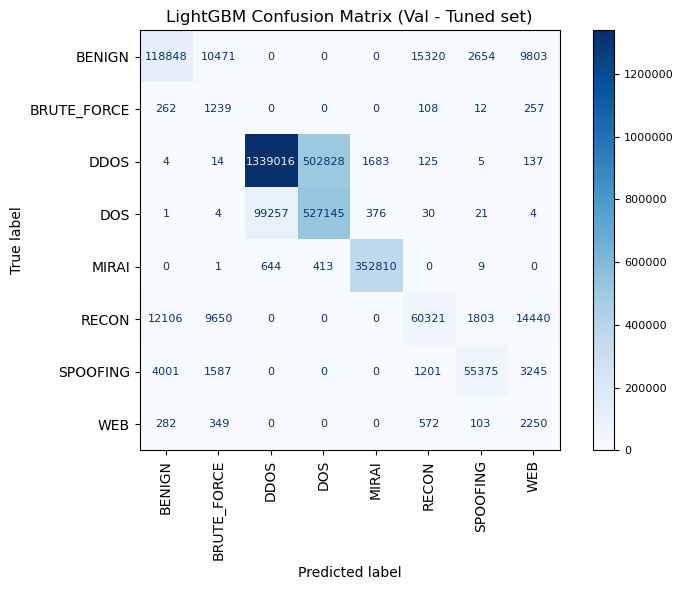


=== TEST - TUNED SET PERFORMANCE ===
Accuracy            : 0.7799
Precision (macro)   : 0.6426
Precision (weighted): 0.8453
Recall (macro)      : 0.7606
Recall (weighted)   : 0.7799
F1 (macro)          : 0.6329
F1 (weighted)       : 0.7963

Classification Report (Test - Tuned):
              precision    recall  f1-score   support

      BENIGN     0.8772    0.7555    0.8119    157096
 BRUTE_FORCE     0.0539    0.6709    0.0998      1878
        DDOS     0.9307    0.7263    0.8159   1843812
         DOS     0.5118    0.8412    0.6364    626838
       MIRAI     0.9941    0.9971    0.9956    353878
       RECON     0.7748    0.6145    0.6854     98319
    SPOOFING     0.9232    0.8482    0.8841     65409
         WEB     0.0752    0.6310    0.1343      3556

    accuracy                         0.7799   3150786
   macro avg     0.6426    0.7606    0.6329   3150786
weighted avg     0.8453    0.7799    0.7963   3150786

Saved table to ..\Tables\LightGBM_Test - Tuned_Classification_Report.

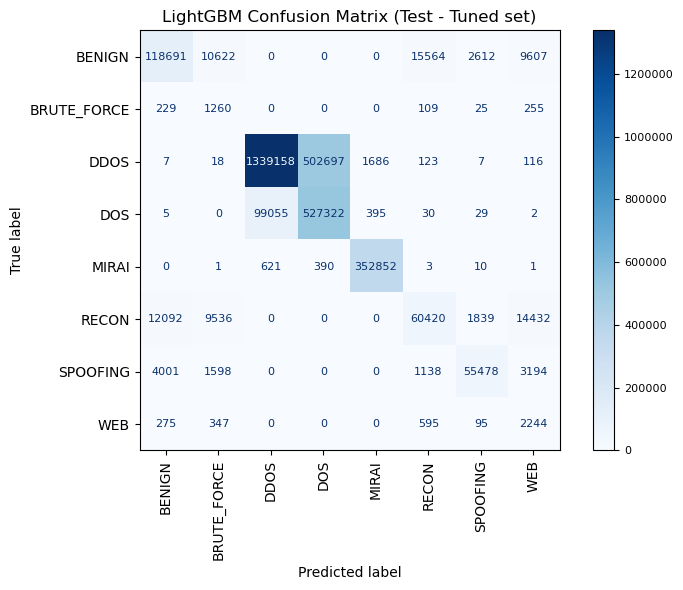

In [12]:
# helper function for evaluation on val/test
def evaluate_multiclass_model(pipeline, X, y_true_enc, split_name="val"):
    """
    Evaluate a multiclass classifier with accuracy, precision, recall,
    macro/weighted F1, classification report, and confusion matrix (saved as image).
    """
    y_pred_enc = pipeline.predict(X)
    y_pred_proba = None
    if hasattr(pipeline.named_steps["model"], "predict_proba"):
        y_pred_proba = pipeline.predict_proba(X)

    # Basic metrics
    acc = accuracy_score(y_true_enc, y_pred_enc)
    f1_macro = f1_score(y_true_enc, y_pred_enc, average="macro")
    f1_weighted = f1_score(y_true_enc, y_pred_enc, average="weighted")

    precision_macro = precision_score(
        y_true_enc, y_pred_enc, average="macro", zero_division=0
    )
    precision_weighted = precision_score(
        y_true_enc, y_pred_enc, average="weighted", zero_division=0
    )

    recall_macro = recall_score(
        y_true_enc, y_pred_enc, average="macro", zero_division=0
    )
    recall_weighted = recall_score(
        y_true_enc, y_pred_enc, average="weighted", zero_division=0
    )

    print(f"\n=== {split_name.upper()} SET PERFORMANCE ===")
    print(f"Accuracy            : {acc:.4f}")
    print(f"Precision (macro)   : {precision_macro:.4f}")
    print(f"Precision (weighted): {precision_weighted:.4f}")
    print(f"Recall (macro)      : {recall_macro:.4f}")
    print(f"Recall (weighted)   : {recall_weighted:.4f}")
    print(f"F1 (macro)          : {f1_macro:.4f}")
    print(f"F1 (weighted)       : {f1_weighted:.4f}")

    # Classification report with readable class names
    report = classification_report(
        y_true_enc,
        y_pred_enc,
        target_names=class_names,
        digits=4
    )
    print(f"\nClassification Report ({split_name}):")
    print(report)

    # Save classification report as a table
    report_dict = metrics.classification_report(
        y_true_enc,
        y_pred_enc,
        target_names=class_names,
        output_dict=True
    )
    report_df = pd.DataFrame(report_dict).T
    save_table(report_df, f"LightGBM_{split_name}_Classification_Report.csv", index=True)

    # Confusion matrix (normalized by true labels)
    cm = confusion_matrix(y_true_enc, y_pred_enc)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax, cmap="Blues", xticks_rotation=90, values_format='d', colorbar=False)
    # 1) Make the numbers inside the cells smaller
    for txt in disp.text_.ravel():
        txt.set_fontsize(8)  # adjust to taste (e.g., 7, 9, etc.)
    # 2) Add a colorbar without scientific notation
    cbar = fig.colorbar(disp.im_, ax=ax, format="%.0f")
    cbar.ax.tick_params(labelsize=8)
    ax.set_title(f"LightGBM Confusion Matrix ({split_name} set)")
    plt.tight_layout()

    save_figure(fig, f"LightGBM_{split_name}_Confusion_Matrix.png", dpi=300)
    plt.show()
    plt.close(fig)

    # Return metrics in case we want to store them programmatically
    return {
        "accuracy": acc,
        "precision_macro": precision_macro,
        "precision_weighted": precision_weighted,
        "recall_macro": recall_macro,
        "recall_weighted": recall_weighted,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "y_pred_enc": y_pred_enc,
        "y_pred_proba": y_pred_proba,
    }

# evaluate on validation and test sets (note: these are imbalanced and realistic)
val_results = evaluate_multiclass_model(
    lgbm_pipeline,
    X_val,
    y_val_enc,
    split_name="Val - Tuned"
)

test_results = evaluate_multiclass_model(
    lgbm_pipeline,
    X_test,
    y_test_enc,
    split_name="Test - Tuned"
)

## Random Forest Model

In [13]:
# define the Random Forest classifier
rf_clf = RandomForestClassifier(
    n_estimators=300,
    criterion="gini",
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    bootstrap=True,
    n_jobs=-1,
    random_state=RANDOM_SEED
)

# build the full modeling pipeline for Random Forest
rf_pipeline = SKPipeline(
    steps=[
        ("preprocess", preprocessor),  # same preprocessor as LightGBM
        ("model", rf_clf),
    ]
)

# cross-validation on the balanced training data (reuse the same cv object)
cv_results_rf = cross_validate(
    rf_pipeline,
    X_train_bal,
    y_train_bal_enc,
    cv=cv,
    scoring=[
        "accuracy",
        "f1_macro", "f1_weighted",
        "precision_macro", "precision_weighted",
        "recall_macro", "recall_weighted",
    ],
    n_jobs=-1,
    return_train_score=False
)

cv_rf_df = pd.DataFrame(cv_results_rf)
cv_rf_summary = cv_rf_df[
    [
        "test_accuracy",
        "test_f1_macro", "test_f1_weighted",
        "test_precision_macro", "test_precision_weighted",
        "test_recall_macro", "test_recall_weighted",
    ]
].agg(["mean", "std"]).T

cv_rf_summary.columns = ["mean", "std"]

print("\nRandom Forest Cross-validation performance (balanced training set):")
print(cv_rf_summary)

# Save CV results and summary for Random Forest
# save_table(cv_rf_df, "RandomForest_CV_Results.csv", index=False)
# save_table(cv_rf_summary, "RandomForest_CV_Summary.csv", index=True)

# Fit the Random Forest pipeline on the full balanced training set
rf_pipeline.fit(X_train_bal, y_train_bal_enc)


Random Forest Cross-validation performance (balanced training set):
                             mean       std
test_accuracy            0.743311  0.001605
test_f1_macro            0.744347  0.001813
test_f1_weighted         0.744347  0.001817
test_precision_macro     0.747351  0.002239
test_precision_weighted  0.747351  0.002242
test_recall_macro        0.743311  0.001600
test_recall_weighted     0.743311  0.001605


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [14]:
# Hyperparameter tuning for Random Forest using RandomizedSearchCV
rf_param_distributions = {
    "model__n_estimators": [200, 300, 400, 500],
    "model__max_depth": [None, 10, 20, 30],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", "log2", None],
    "model__bootstrap": [True, False],
}

rf_random_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=rf_param_distributions,
    n_iter=50,  # number of random combinations to try
    scoring={
        "accuracy": "accuracy",
        "f1_macro": "f1_macro",
        "f1_weighted": "f1_weighted",
    },
    refit="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=RANDOM_SEED,
    return_train_score=False,
)

# Fit the tuner on the balanced training set
rf_random_search.fit(X_train_bal, y_train_bal_enc)

print("\nBest Random Forest parameters found (RandomizedSearchCV):")
print(rf_random_search.best_params_)
print(f"\nBest CV f1_macro (tuned Random Forest): {rf_random_search.best_score_:.4f}")

# Store and (optionally) save detailed CV results from the search
rf_search_cv_df = pd.DataFrame(rf_random_search.cv_results_)
# save_table(rf_search_cv_df, "RandomForest_RandomSearch_CV_Results.csv", index=False)

# Get the tuned pipeline and overwrite rf_pipeline so the rest of the code
# uses the best-found Random Forest model
rf_best_pipeline = rf_random_search.best_estimator_
rf_pipeline = rf_best_pipeline

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best Random Forest parameters found (RandomizedSearchCV):
{'model__n_estimators': 500, 'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_features': 'sqrt', 'model__max_depth': 20, 'model__bootstrap': False}

Best CV f1_macro (tuned Random Forest): 0.7535



=== RANDOM FOREST VAL - TUNED SET PERFORMANCE ===
Accuracy            : 0.7789
Precision (macro)   : 0.6406
Precision (weighted): 0.8451
Recall (macro)      : 0.7531
Recall (weighted)   : 0.7789
F1 (macro)          : 0.6290
F1 (weighted)       : 0.7956

Random Forest Classification Report (Val - Tuned):
              precision    recall  f1-score   support

      BENIGN     0.8730    0.7432    0.8029    157096
 BRUTE_FORCE     0.0506    0.6347    0.0937      1878
        DDOS     0.9311    0.7259    0.8158   1843812
         DOS     0.5117    0.8418    0.6365    626838
       MIRAI     0.9932    0.9972    0.9952    353877
       RECON     0.7688    0.6116    0.6813     98320
    SPOOFING     0.9256    0.8392    0.8803     65409
         WEB     0.0704    0.6308    0.1267      3556

    accuracy                         0.7789   3150786
   macro avg     0.6406    0.7531    0.6290   3150786
weighted avg     0.8451    0.7789    0.7956   3150786

Saved table to ..\Tables\RandomForest_Val -

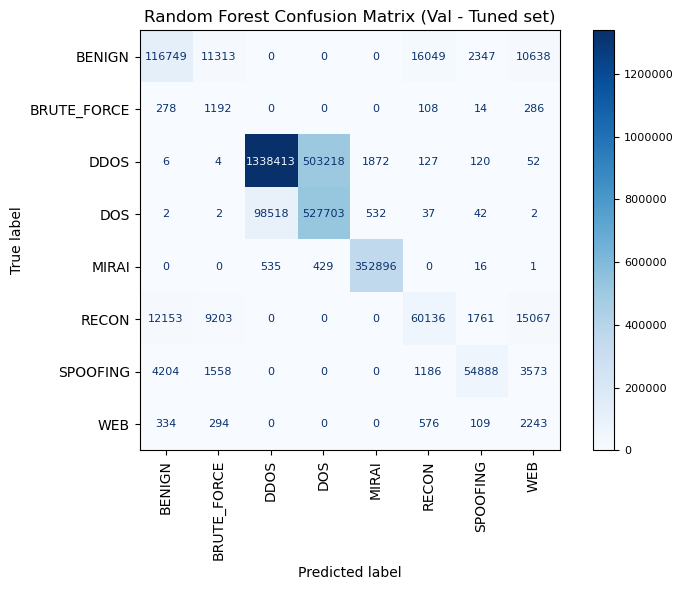


=== RANDOM FOREST TEST - TUNED SET PERFORMANCE ===
Accuracy            : 0.7787
Precision (macro)   : 0.6400
Precision (weighted): 0.8450
Recall (macro)      : 0.7511
Recall (weighted)   : 0.7787
F1 (macro)          : 0.6286
F1 (weighted)       : 0.7953

Random Forest Classification Report (Test - Tuned):
              precision    recall  f1-score   support

      BENIGN     0.8733    0.7419    0.8022    157096
 BRUTE_FORCE     0.0501    0.6257    0.0928      1878
        DDOS     0.9312    0.7254    0.8155   1843812
         DOS     0.5113    0.8422    0.6363    626838
       MIRAI     0.9932    0.9973    0.9953    353878
       RECON     0.7669    0.6118    0.6806     98319
    SPOOFING     0.9238    0.8407    0.8803     65409
         WEB     0.0698    0.6240    0.1255      3556

    accuracy                         0.7787   3150786
   macro avg     0.6400    0.7511    0.6286   3150786
weighted avg     0.8450    0.7787    0.7953   3150786

Saved table to ..\Tables\RandomForest_Tes

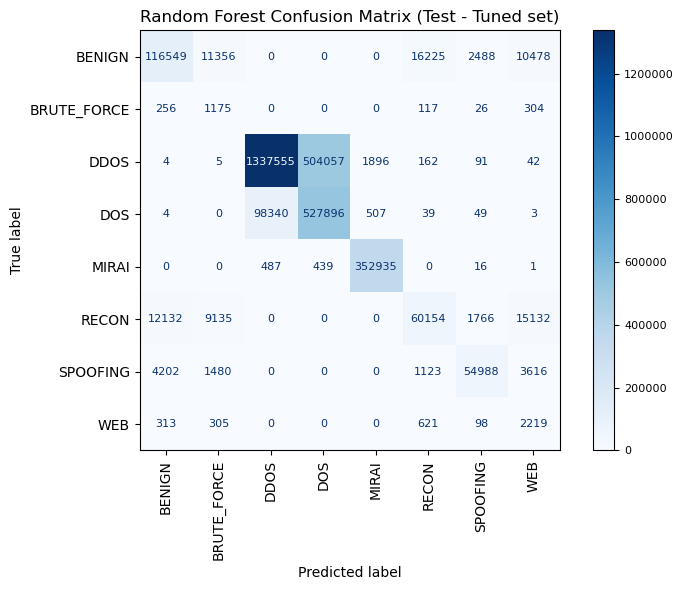

In [15]:
def evaluate_multiclass_model_rf(pipeline, X, y_true_enc, split_name="val"):
    """
    Evaluate a multiclass Random Forest classifier with accuracy, precision,
    recall, macro/weighted F1, classification report, and confusion matrix.
    """
    y_pred_enc = pipeline.predict(X)
    y_pred_proba = None
    if hasattr(pipeline.named_steps["model"], "predict_proba"):
        y_pred_proba = pipeline.predict_proba(X)

    # Basic metrics
    acc = accuracy_score(y_true_enc, y_pred_enc)
    f1_macro = f1_score(y_true_enc, y_pred_enc, average="macro")
    f1_weighted = f1_score(y_true_enc, y_pred_enc, average="weighted")

    precision_macro = precision_score(
        y_true_enc, y_pred_enc, average="macro", zero_division=0
    )
    precision_weighted = precision_score(
        y_true_enc, y_pred_enc, average="weighted", zero_division=0
    )

    recall_macro = recall_score(
        y_true_enc, y_pred_enc, average="macro", zero_division=0
    )
    recall_weighted = recall_score(
        y_true_enc, y_pred_enc, average="weighted", zero_division=0
    )

    print(f"\n=== RANDOM FOREST {split_name.upper()} SET PERFORMANCE ===")
    print(f"Accuracy            : {acc:.4f}")
    print(f"Precision (macro)   : {precision_macro:.4f}")
    print(f"Precision (weighted): {precision_weighted:.4f}")
    print(f"Recall (macro)      : {recall_macro:.4f}")
    print(f"Recall (weighted)   : {recall_weighted:.4f}")
    print(f"F1 (macro)          : {f1_macro:.4f}")
    print(f"F1 (weighted)       : {f1_weighted:.4f}")

    # Classification report with readable class names
    report = classification_report(
        y_true_enc,
        y_pred_enc,
        target_names=class_names,
        digits=4
    )
    print(f"\nRandom Forest Classification Report ({split_name}):")
    print(report)

    # Optionally save classification report as a table
    report_dict = metrics.classification_report(
        y_true_enc,
        y_pred_enc,
        target_names=class_names,
        output_dict=True
    )
    report_df = pd.DataFrame(report_dict).T
    save_table(report_df, f"RandomForest_{split_name}_Classification_Report.csv", index=True)

    # Confusion matrix (normalized by true labels)
    cm = confusion_matrix(y_true_enc, y_pred_enc)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax, cmap="Blues", xticks_rotation=90, values_format='d', colorbar=False)

    # Make the numbers inside the cells smaller
    for txt in disp.text_.ravel():
        txt.set_fontsize(8)

    # Add a colorbar without scientific notation
    cbar = fig.colorbar(disp.im_, ax=ax, format="%.0f")
    cbar.ax.tick_params(labelsize=8)

    ax.set_title(f"Random Forest Confusion Matrix ({split_name} set)")
    plt.tight_layout()

    save_figure(fig, f"RandomForest_{split_name}_Confusion_Matrix.png", dpi=300)
    plt.show()
    plt.close(fig)

    # Return metrics in case we want to store them programmatically
    return {
        "accuracy": acc,
        "precision_macro": precision_macro,
        "precision_weighted": precision_weighted,
        "recall_macro": recall_macro,
        "recall_weighted": recall_weighted,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "y_pred_enc": y_pred_enc,
        "y_pred_proba": y_pred_proba,
    }


# Evaluate Random Forest on validation and test sets

rf_val_results = evaluate_multiclass_model_rf(
    rf_pipeline,
    X_val,
    y_val_enc,
    split_name="Val - Tuned"
)

rf_test_results = evaluate_multiclass_model_rf(
    rf_pipeline,
    X_test,
    y_test_enc,
    split_name="Test - Tuned"
)

## CatBoost Model

In [16]:
# CatBoost model development
# define the CatBoost classifier
cat_clf = CatBoostClassifier(
    loss_function="MultiClass",
    eval_metric="Accuracy",
    iterations=300,
    learning_rate=0.1,
    depth=8,
    l2_leaf_reg=3.0,
    bootstrap_type="Bernoulli",
    subsample=0.8,
    random_state=RANDOM_SEED,
    thread_count=-1,
    verbose=0,
    allow_writing_files=False
)

# build the full modeling pipeline for CatBoost
cat_pipeline = SKPipeline(
    steps=[
        ("preprocess", preprocessor),  # same ColumnTransformer as LightGBM / RF
        ("model", cat_clf),
    ]
)

# cross-validation on the balanced training data (reuse the same cv object)
cv_results_cat = cross_validate(
    cat_pipeline,
    X_train_bal,
    y_train_bal_enc,
    cv=cv,
    scoring=[
        "accuracy",
        "f1_macro", "f1_weighted",
        "precision_macro", "precision_weighted",
        "recall_macro", "recall_weighted",
    ],
    n_jobs=-1,
    return_train_score=False
)

cv_cat_df = pd.DataFrame(cv_results_cat)
cv_cat_summary = cv_cat_df[
    [
        "test_accuracy",
        "test_f1_macro", "test_f1_weighted",
        "test_precision_macro", "test_precision_weighted",
        "test_recall_macro", "test_recall_weighted",
    ]
].agg(["mean", "std"]).T

cv_cat_summary.columns = ["mean", "std"]

print("\nCatBoost Cross-validation performance (balanced training set):")
print(cv_cat_summary)

# save CV results and summary for CatBoost
# save_table(cv_cat_df, "CatBoost_CV_Results.csv", index=False)
# save_table(cv_cat_summary, "CatBoost_CV_Summary.csv", index=True)

# fit the CatBoost pipeline on the full balanced training set
cat_pipeline.fit(X_train_bal, y_train_bal_enc)


CatBoost Cross-validation performance (balanced training set):
                             mean       std
test_accuracy            0.753737  0.002772
test_f1_macro            0.754112  0.002719
test_f1_weighted         0.754112  0.002720
test_precision_macro     0.758211  0.003307
test_precision_weighted  0.758211  0.003307
test_recall_macro        0.753737  0.002771
test_recall_weighted     0.753737  0.002772


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [17]:
# Hyperparameter tuning for CatBoost using RandomizedSearchCV
cat_param_distributions = {
    "model__iterations": [200, 300, 400, 500],
    "model__depth": [4, 6, 8, 10],
    "model__learning_rate": [0.01, 0.03, 0.05, 0.1],
    "model__l2_leaf_reg": [1.0, 3.0, 5.0, 7.0, 9.0],
    "model__subsample": [0.7, 0.8, 0.9, 1.0],
    "model__bootstrap_type": ["Bayesian", "Bernoulli"],
}

cat_random_search = RandomizedSearchCV(
    estimator=cat_pipeline,
    param_distributions=cat_param_distributions,
    n_iter=50,  # number of random combinations to try
    scoring={
        "accuracy": "accuracy",
        "f1_macro": "f1_macro",
        "f1_weighted": "f1_weighted",
    },
    refit="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=RANDOM_SEED,
    return_train_score=False,
)

# Fit the tuner on the balanced training set
cat_random_search.fit(X_train_bal, y_train_bal_enc)

print("\nBest CatBoost parameters found (RandomizedSearchCV):")
print(cat_random_search.best_params_)
print(f"\nBest CV f1_macro (tuned CatBoost): {cat_random_search.best_score_:.4f}")

# Store and (optionally) save detailed CV results from the search
cat_search_cv_df = pd.DataFrame(cat_random_search.cv_results_)
# save_table(cat_search_cv_df, "CatBoost_RandomSearch_CV_Results.csv", index=False)

# Get the tuned pipeline and overwrite cat_pipeline so the rest of the code
# uses the best-found CatBoost model
cat_best_pipeline = cat_random_search.best_estimator_
cat_pipeline = cat_best_pipeline

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best CatBoost parameters found (RandomizedSearchCV):
{'model__subsample': 0.8, 'model__learning_rate': 0.1, 'model__l2_leaf_reg': 1.0, 'model__iterations': 500, 'model__depth': 8, 'model__bootstrap_type': 'Bernoulli'}

Best CV f1_macro (tuned CatBoost): 0.7577



=== CATBOOST VAL - TUNED SET PERFORMANCE ===
Accuracy            : 0.7777
Precision (macro)   : 0.6409
Precision (weighted): 0.8473
Recall (macro)      : 0.7580
Recall (weighted)   : 0.7777
F1 (macro)          : 0.6298
F1 (weighted)       : 0.7946

CatBoost Classification Report (Val - Tuned):
              precision    recall  f1-score   support

      BENIGN     0.8770    0.7501    0.8086    157096
 BRUTE_FORCE     0.0515    0.6592    0.0955      1878
        DDOS     0.9354    0.7192    0.8132   1843812
         DOS     0.5093    0.8538    0.6380    626838
       MIRAI     0.9933    0.9972    0.9952    353877
       RECON     0.7762    0.6056    0.6804     98320
    SPOOFING     0.9130    0.8472    0.8789     65409
         WEB     0.0716    0.6313    0.1287      3556

    accuracy                         0.7777   3150786
   macro avg     0.6409    0.7580    0.6298   3150786
weighted avg     0.8473    0.7777    0.7946   3150786

Saved table to ..\Tables\CatBoost_Val - Tuned_Classif

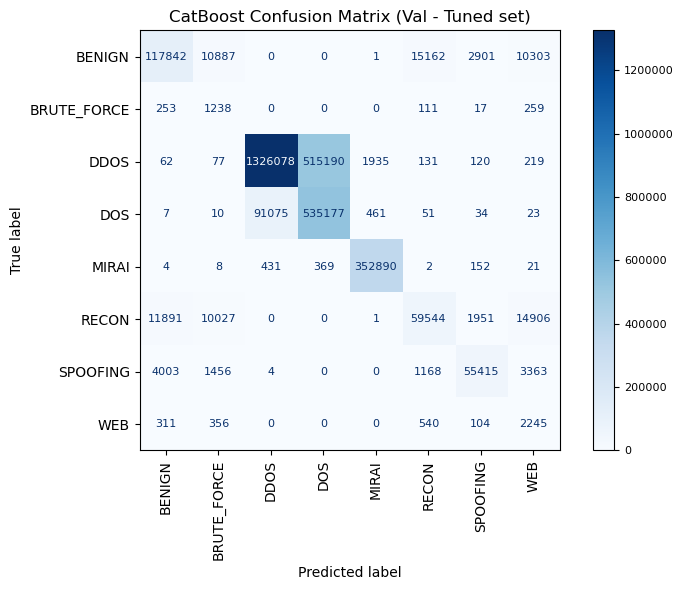


=== CATBOOST TEST - TUNED SET PERFORMANCE ===
Accuracy            : 0.7778
Precision (macro)   : 0.6406
Precision (weighted): 0.8474
Recall (macro)      : 0.7577
Recall (weighted)   : 0.7778
F1 (macro)          : 0.6297
F1 (weighted)       : 0.7947

CatBoost Classification Report (Test - Tuned):
              precision    recall  f1-score   support

      BENIGN     0.8767    0.7492    0.8080    157096
 BRUTE_FORCE     0.0525    0.6640    0.0972      1878
        DDOS     0.9357    0.7193    0.8133   1843812
         DOS     0.5095    0.8541    0.6383    626838
       MIRAI     0.9932    0.9973    0.9952    353878
       RECON     0.7733    0.6056    0.6792     98319
    SPOOFING     0.9131    0.8484    0.8795     65409
         WEB     0.0708    0.6240    0.1271      3556

    accuracy                         0.7778   3150786
   macro avg     0.6406    0.7577    0.6297   3150786
weighted avg     0.8474    0.7778    0.7947   3150786

Saved table to ..\Tables\CatBoost_Test - Tuned_Clas

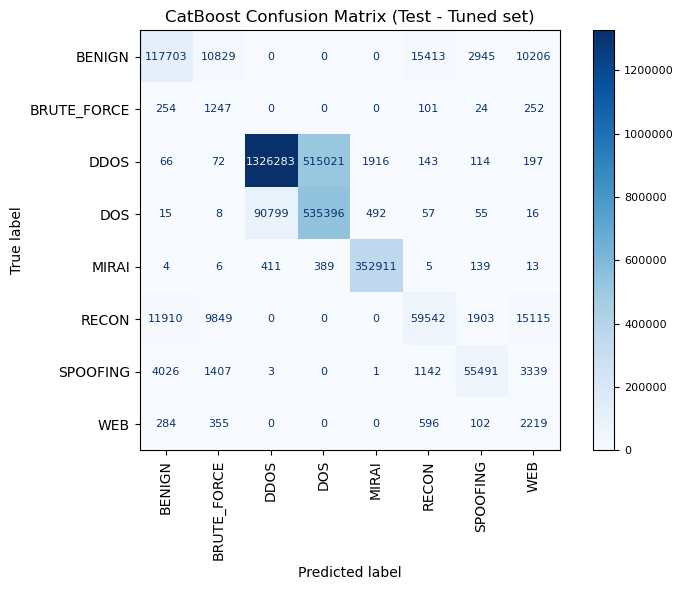

In [18]:
# helper function to evaluate validation and testing of catboost model
def evaluate_multiclass_model_catboost(pipeline, X, y_true_enc, split_name="val"):
    """
    Evaluate a multiclass CatBoost classifier with accuracy, precision,
    recall, macro/weighted F1, classification report, and confusion matrix.
    """
    y_pred_enc = pipeline.predict(X)
    y_pred_proba = None
    if hasattr(pipeline.named_steps["model"], "predict_proba"):
        y_pred_proba = pipeline.predict_proba(X)

    # Basic metrics
    acc = accuracy_score(y_true_enc, y_pred_enc)
    f1_macro = f1_score(y_true_enc, y_pred_enc, average="macro")
    f1_weighted = f1_score(y_true_enc, y_pred_enc, average="weighted")

    precision_macro = precision_score(
        y_true_enc, y_pred_enc, average="macro", zero_division=0
    )
    precision_weighted = precision_score(
        y_true_enc, y_pred_enc, average="weighted", zero_division=0
    )

    recall_macro = recall_score(
        y_true_enc, y_pred_enc, average="macro", zero_division=0
    )
    recall_weighted = recall_score(
        y_true_enc, y_pred_enc, average="weighted", zero_division=0
    )

    print(f"\n=== CATBOOST {split_name.upper()} SET PERFORMANCE ===")
    print(f"Accuracy            : {acc:.4f}")
    print(f"Precision (macro)   : {precision_macro:.4f}")
    print(f"Precision (weighted): {precision_weighted:.4f}")
    print(f"Recall (macro)      : {recall_macro:.4f}")
    print(f"Recall (weighted)   : {recall_weighted:.4f}")
    print(f"F1 (macro)          : {f1_macro:.4f}")
    print(f"F1 (weighted)       : {f1_weighted:.4f}")

    # Classification report with readable class names
    report = classification_report(
        y_true_enc,
        y_pred_enc,
        target_names=class_names,
        digits=4
    )
    print(f"\nCatBoost Classification Report ({split_name}):")
    print(report)

    # Optionally save classification report as a table
    report_dict = metrics.classification_report(
        y_true_enc,
        y_pred_enc,
        target_names=class_names,
        output_dict=True
    )
    report_df = pd.DataFrame(report_dict).T
    save_table(report_df, f"CatBoost_{split_name}_Classification_Report.csv", index=True)

    # Confusion matrix
    cm = confusion_matrix(y_true_enc, y_pred_enc)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax, cmap="Blues", xticks_rotation=90, values_format='d', colorbar=False)

    # Make the numbers inside the cells smaller
    for txt in disp.text_.ravel():
        txt.set_fontsize(8)

    # Add a colorbar without scientific notation
    cbar = fig.colorbar(disp.im_, ax=ax, format="%.0f")
    cbar.ax.tick_params(labelsize=8)

    ax.set_title(f"CatBoost Confusion Matrix ({split_name} set)")
    plt.tight_layout()

    save_figure(fig, f"CatBoost_{split_name}_Confusion_Matrix.png", dpi=300)
    plt.show()
    plt.close(fig)

    # Return metrics in case we want to store them programmatically
    return {
        "accuracy": acc,
        "precision_macro": precision_macro,
        "precision_weighted": precision_weighted,
        "recall_macro": recall_macro,
        "recall_weighted": recall_weighted,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "y_pred_enc": y_pred_enc,
        "y_pred_proba": y_pred_proba,
    }

# Evaluate CatBoost on validation and test sets

cat_val_results = evaluate_multiclass_model_catboost(
    cat_pipeline,
    X_val,
    y_val_enc,
    split_name="Val - Tuned"
)

cat_test_results = evaluate_multiclass_model_catboost(
    cat_pipeline,
    X_test,
    y_test_enc,
    split_name="Test - Tuned"
)

## Adaboost Model

In [19]:
# AdaBoost model development
# define the AdaBoost classifier
ada_clf = AdaBoostClassifier(
    n_estimators=200,
    learning_rate=0.1,
    random_state=RANDOM_SEED
)

# build the full modeling pipeline for AdaBoost
ada_pipeline = SKPipeline(
    steps=[
        ("preprocess", preprocessor),  # same ColumnTransformer as LightGBM / RF / CatBoost
        ("model", ada_clf),
    ]
)

# cross-validation on the balanced training data (reuse the same cv object)
cv_results_ada = cross_validate(
    ada_pipeline,
    X_train_bal,
    y_train_bal_enc,
    cv=cv,
    scoring=[
        "accuracy",
        "f1_macro", "f1_weighted",
        "precision_macro", "precision_weighted",
        "recall_macro", "recall_weighted",
    ],
    n_jobs=-1,
    return_train_score=False
)

cv_ada_df = pd.DataFrame(cv_results_ada)
cv_ada_summary = cv_ada_df[
    [
        "test_accuracy",
        "test_f1_macro", "test_f1_weighted",
        "test_precision_macro", "test_precision_weighted",
        "test_recall_macro", "test_recall_weighted",
    ]
].agg(["mean", "std"]).T

cv_ada_summary.columns = ["mean", "std"]

print("\nAdaBoost Cross-validation performance (balanced training set):")
print(cv_ada_summary)

# optionally save CV results and summary for AdaBoost
# save_table(cv_ada_df, "AdaBoost_CV_Results.csv", index=False)
# save_table(cv_ada_summary, "AdaBoost_CV_Summary.csv", index=True)

# fit the AdaBoost pipeline on the full balanced training set
ada_pipeline.fit(X_train_bal, y_train_bal_enc)


AdaBoost Cross-validation performance (balanced training set):
                             mean       std
test_accuracy            0.290706  0.002431
test_f1_macro            0.167960  0.002912
test_f1_weighted         0.167954  0.002921
test_precision_macro     0.193414  0.000110
test_precision_weighted  0.193411  0.000118
test_recall_macro        0.290721  0.002420
test_recall_weighted     0.290706  0.002431


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [20]:
# Hyperparameter tuning for AdaBoost using RandomizedSearchCV
ada_param_distributions = {
    "model__n_estimators": [100, 150, 200, 250, 300],
    "model__learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "model__algorithm": ["SAMME.R", "SAMME"],
}

ada_random_search = RandomizedSearchCV(
    estimator=ada_pipeline,
    param_distributions=ada_param_distributions,
    n_iter=50,  # number of random combinations to try
    scoring={
        "accuracy": "accuracy",
        "f1_macro": "f1_macro",
        "f1_weighted": "f1_weighted",
    },
    refit="f1_macro",
    cv=cv,              # same StratifiedKFold as other models
    n_jobs=-1,
    verbose=2,
    random_state=RANDOM_SEED,
    return_train_score=False,
)

# Fit the tuner on the balanced training set
ada_random_search.fit(X_train_bal, y_train_bal_enc)

print("\nBest AdaBoost parameters found (RandomizedSearchCV):")
print(ada_random_search.best_params_)
print(f"\nBest CV f1_macro (tuned AdaBoost): {ada_random_search.best_score_:.4f}")

# Store and (optionally) save detailed CV results from the search
ada_search_cv_df = pd.DataFrame(ada_random_search.cv_results_)
# save_table(ada_search_cv_df, "AdaBoost_RandomSearch_CV_Results.csv", index=False)

# Get the tuned pipeline and overwrite ada_pipeline so the rest of the code
# uses the best-found AdaBoost model
ada_best_pipeline = ada_random_search.best_estimator_
ada_pipeline = ada_best_pipeline

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best AdaBoost parameters found (RandomizedSearchCV):
{'model__n_estimators': 150, 'model__learning_rate': 0.3, 'model__algorithm': 'SAMME'}

Best CV f1_macro (tuned AdaBoost): 0.5243



=== ADABOOST VAL - TUNED SET PERFORMANCE ===
Accuracy            : 0.6820
Precision (macro)   : 0.5140
Precision (weighted): 0.6738
Recall (macro)      : 0.5227
Recall (weighted)   : 0.6820
F1 (macro)          : 0.4811
F1 (weighted)       : 0.6734

AdaBoost Classification Report (Val - Tuned):
              precision    recall  f1-score   support

      BENIGN     0.7315    0.6042    0.6618    157096
 BRUTE_FORCE     0.0771    0.3253    0.1247      1878
        DDOS     0.7677    0.8596    0.8111   1843812
         DOS     0.3132    0.2350    0.2685    626838
       MIRAI     0.7998    0.6535    0.7193    353877
       RECON     0.6529    0.5384    0.5902     98320
    SPOOFING     0.7449    0.5405    0.6264     65409
         WEB     0.0249    0.4255    0.0470      3556

    accuracy                         0.6820   3150786
   macro avg     0.5140    0.5227    0.4811   3150786
weighted avg     0.6738    0.6820    0.6734   3150786

Saved table to ..\Tables\AdaBoost_Val - Tuned_Classif

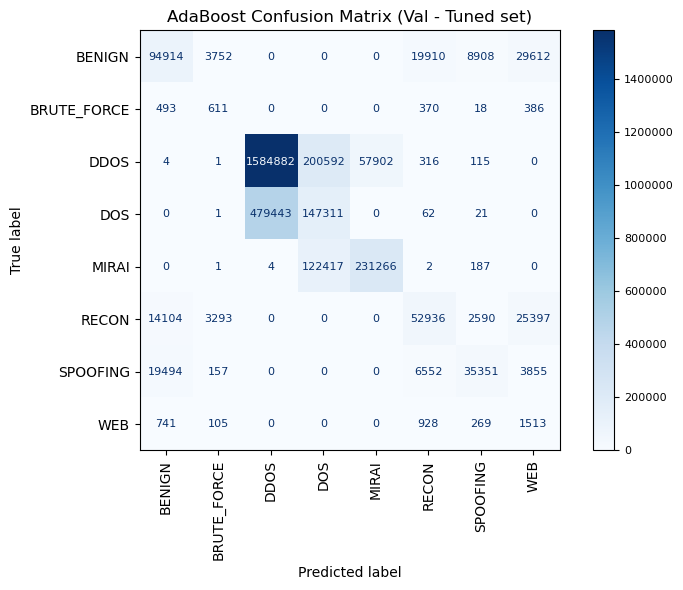


=== ADABOOST TEST - TUNED SET PERFORMANCE ===
Accuracy            : 0.6820
Precision (macro)   : 0.5142
Precision (weighted): 0.6738
Recall (macro)      : 0.5214
Recall (weighted)   : 0.6820
F1 (macro)          : 0.4813
F1 (weighted)       : 0.6734

AdaBoost Classification Report (Test - Tuned):
              precision    recall  f1-score   support

      BENIGN     0.7334    0.6057    0.6635    157096
 BRUTE_FORCE     0.0770    0.3264    0.1246      1878
        DDOS     0.7676    0.8595    0.8109   1843812
         DOS     0.3128    0.2344    0.2679    626838
       MIRAI     0.8000    0.6545    0.7200    353878
       RECON     0.6520    0.5355    0.5880     98319
    SPOOFING     0.7467    0.5447    0.6299     65409
         WEB     0.0240    0.4109    0.0454      3556

    accuracy                         0.6820   3150786
   macro avg     0.5142    0.5214    0.4813   3150786
weighted avg     0.6738    0.6820    0.6734   3150786

Saved table to ..\Tables\AdaBoost_Test - Tuned_Clas

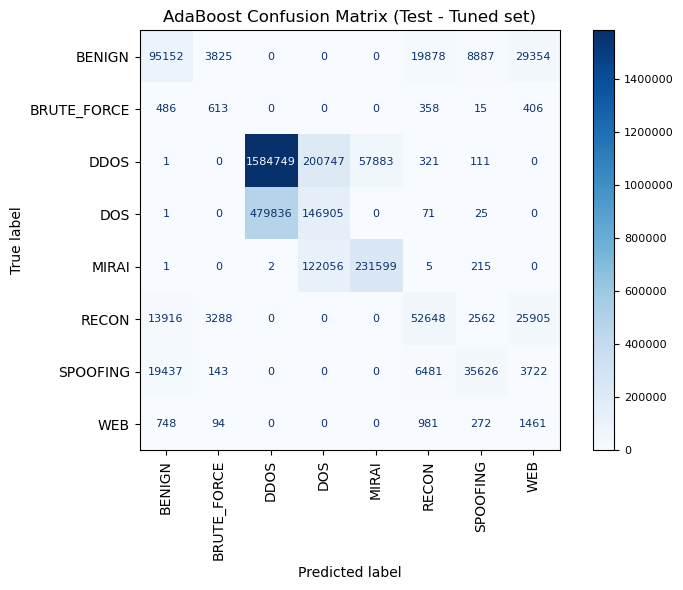

In [21]:
# helper function to evaluate validation and testing of AdaBoost model
def evaluate_multiclass_model_adaboost(pipeline, X, y_true_enc, split_name="val"):
    """
    Evaluate a multiclass AdaBoost classifier with accuracy, precision,
    recall, macro/weighted F1, classification report, and confusion matrix.
    """
    y_pred_enc = pipeline.predict(X)
    y_pred_proba = None
    if hasattr(pipeline.named_steps["model"], "predict_proba"):
        y_pred_proba = pipeline.predict_proba(X)

    # Basic metrics
    acc = accuracy_score(y_true_enc, y_pred_enc)
    f1_macro = f1_score(y_true_enc, y_pred_enc, average="macro")
    f1_weighted = f1_score(y_true_enc, y_pred_enc, average="weighted")

    precision_macro = precision_score(
        y_true_enc, y_pred_enc, average="macro", zero_division=0
    )
    precision_weighted = precision_score(
        y_true_enc, y_pred_enc, average="weighted", zero_division=0
    )

    recall_macro = recall_score(
        y_true_enc, y_pred_enc, average="macro", zero_division=0
    )
    recall_weighted = recall_score(
        y_true_enc, y_pred_enc, average="weighted", zero_division=0
    )

    print(f"\n=== ADABOOST {split_name.upper()} SET PERFORMANCE ===")
    print(f"Accuracy            : {acc:.4f}")
    print(f"Precision (macro)   : {precision_macro:.4f}")
    print(f"Precision (weighted): {precision_weighted:.4f}")
    print(f"Recall (macro)      : {recall_macro:.4f}")
    print(f"Recall (weighted)   : {recall_weighted:.4f}")
    print(f"F1 (macro)          : {f1_macro:.4f}")
    print(f"F1 (weighted)       : {f1_weighted:.4f}")

    # Classification report with readable class names
    report = classification_report(
        y_true_enc,
        y_pred_enc,
        target_names=class_names,
        digits=4
    )
    print(f"\nAdaBoost Classification Report ({split_name}):")
    print(report)

    # Optionally save classification report as a table
    report_dict = metrics.classification_report(
        y_true_enc,
        y_pred_enc,
        target_names=class_names,
        output_dict=True
    )
    report_df = pd.DataFrame(report_dict).T
    save_table(report_df, f"AdaBoost_{split_name}_Classification_Report.csv", index=True)

    # Confusion matrix
    cm = confusion_matrix(y_true_enc, y_pred_enc)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax, cmap="Blues", xticks_rotation=90, values_format='d', colorbar=False)

    # Make the numbers inside the cells smaller
    for txt in disp.text_.ravel():
        txt.set_fontsize(8)

    # Add a colorbar without scientific notation
    cbar = fig.colorbar(disp.im_, ax=ax, format="%.0f")
    cbar.ax.tick_params(labelsize=8)

    ax.set_title(f"AdaBoost Confusion Matrix ({split_name} set)")
    plt.tight_layout()

    save_figure(fig, f"AdaBoost_{split_name}_Confusion_Matrix.png", dpi=300)
    plt.show()
    plt.close(fig)

    # Return metrics in case we want to store them programmatically
    return {
        "accuracy": acc,
        "precision_macro": precision_macro,
        "precision_weighted": precision_weighted,
        "recall_macro": recall_macro,
        "recall_weighted": recall_weighted,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "y_pred_enc": y_pred_enc,
        "y_pred_proba": y_pred_proba,
    }


# Evaluate AdaBoost on validation and test sets

ada_val_results = evaluate_multiclass_model_adaboost(
    ada_pipeline,
    X_val,
    y_val_enc,
    split_name="Val - Tuned"
)

ada_test_results = evaluate_multiclass_model_adaboost(
    ada_pipeline,
    X_test,
    y_test_enc,
    split_name="Test - Tuned"
)

## XGBoost Model

In [22]:
# XGBoost model development
# define the XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    objective="multi:softprob",   # multiclass probability output
    eval_metric="mlogloss",
    n_estimators=300,
    learning_rate=0.1,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    n_jobs=-1,
    random_state=RANDOM_SEED,
    tree_method="hist"            # efficient histogram-based algorithm
)

# build the full modeling pipeline for XGBoost
xgb_pipeline = SKPipeline(
    steps=[
        ("preprocess", preprocessor),  # same ColumnTransformer as LightGBM / RF / CatBoost / AdaBoost
        ("model", xgb_clf),
    ]
)

# cross-validation on the balanced training data (reuse the same cv object)
cv_results_xgb = cross_validate(
    xgb_pipeline,
    X_train_bal,
    y_train_bal_enc,
    cv=cv,
    scoring=[
        "accuracy",
        "f1_macro", "f1_weighted",
        "precision_macro", "precision_weighted",
        "recall_macro", "recall_weighted",
    ],
    n_jobs=-1,
    return_train_score=False
)

cv_xgb_df = pd.DataFrame(cv_results_xgb)
cv_xgb_summary = cv_xgb_df[
    [
        "test_accuracy",
        "test_f1_macro", "test_f1_weighted",
        "test_precision_macro", "test_precision_weighted",
        "test_recall_macro", "test_recall_weighted",
    ]
].agg(["mean", "std"]).T

cv_xgb_summary.columns = ["mean", "std"]

print("\nXGBoost Cross-validation performance (balanced training set):")
print(cv_xgb_summary)

# optionally save CV results and summary for XGBoost
# save_table(cv_xgb_df, "XGBoost_CV_Results.csv", index=False)
# save_table(cv_xgb_summary, "XGBoost_CV_Summary.csv", index=True)

# fit the XGBoost pipeline on the full balanced training set
xgb_pipeline.fit(X_train_bal, y_train_bal_enc)


XGBoost Cross-validation performance (balanced training set):
                             mean       std
test_accuracy            0.755648  0.003359
test_f1_macro            0.756267  0.003284
test_f1_weighted         0.756267  0.003281
test_precision_macro     0.759184  0.003727
test_precision_weighted  0.759184  0.003724
test_recall_macro        0.755648  0.003363
test_recall_weighted     0.755648  0.003359


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [23]:
# Hyperparameter tuning for XGBoost using RandomizedSearchCV
xgb_param_distributions = {
    "model__n_estimators": [200, 300, 400, 500],
    "model__max_depth": [3, 5, 7, 9],
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__subsample": [0.7, 0.8, 0.9, 1.0],
    "model__colsample_bytree": [0.7, 0.8, 0.9, 1.0],
    "model__min_child_weight": [1, 3, 5, 7],
    "model__gamma": [0.0, 0.1, 0.2, 0.5],
    "model__reg_lambda": [0.5, 1.0, 1.5, 2.0],
    "model__reg_alpha": [0.0, 0.1, 0.5, 1.0],
}

xgb_random_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=xgb_param_distributions,
    n_iter=50,  # number of random combinations to try
    scoring={
        "accuracy": "accuracy",
        "f1_macro": "f1_macro",
        "f1_weighted": "f1_weighted",
    },
    refit="f1_macro",
    cv=cv,              # same StratifiedKFold as other models
    n_jobs=-1,
    verbose=2,
    random_state=RANDOM_SEED,
    return_train_score=False,
)

# Fit the tuner on the balanced training set
xgb_random_search.fit(X_train_bal, y_train_bal_enc)

print("\nBest XGBoost parameters found (RandomizedSearchCV):")
print(xgb_random_search.best_params_)
print(f"\nBest CV f1_macro (tuned XGBoost): {xgb_random_search.best_score_:.4f}")

# Store and (optionally) save detailed CV results from the search
xgb_search_cv_df = pd.DataFrame(xgb_random_search.cv_results_)
# save_table(xgb_search_cv_df, "XGBoost_RandomSearch_CV_Results.csv", index=False)

# Get the tuned pipeline and overwrite xgb_pipeline so the rest of the code
# uses the best-found XGBoost model
xgb_best_pipeline = xgb_random_search.best_estimator_
xgb_pipeline = xgb_best_pipeline

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best XGBoost parameters found (RandomizedSearchCV):
{'model__subsample': 0.8, 'model__reg_lambda': 1.0, 'model__reg_alpha': 1.0, 'model__n_estimators': 400, 'model__min_child_weight': 3, 'model__max_depth': 7, 'model__learning_rate': 0.1, 'model__gamma': 0.5, 'model__colsample_bytree': 0.7}

Best CV f1_macro (tuned XGBoost): 0.7591



=== XGBOOST VAL - TUNED SET PERFORMANCE ===
Accuracy            : 0.7789
Precision (macro)   : 0.6412
Precision (weighted): 0.8449
Recall (macro)      : 0.7589
Recall (weighted)   : 0.7789
F1 (macro)          : 0.6302
F1 (weighted)       : 0.7955

XGBoost Classification Report (Val - Tuned):
              precision    recall  f1-score   support

      BENIGN     0.8770    0.7492    0.8081    157096
 BRUTE_FORCE     0.0514    0.6629    0.0954      1878
        DDOS     0.9306    0.7258    0.8155   1843812
         DOS     0.5115    0.8410    0.6361    626838
       MIRAI     0.9928    0.9968    0.9948    353877
       RECON     0.7745    0.6060    0.6800     98320
    SPOOFING     0.9187    0.8452    0.8804     65409
         WEB     0.0731    0.6443    0.1313      3556

    accuracy                         0.7789   3150786
   macro avg     0.6412    0.7589    0.6302   3150786
weighted avg     0.8449    0.7789    0.7955   3150786

Saved table to ..\Tables\XGBoost_Val - Tuned_Classifica

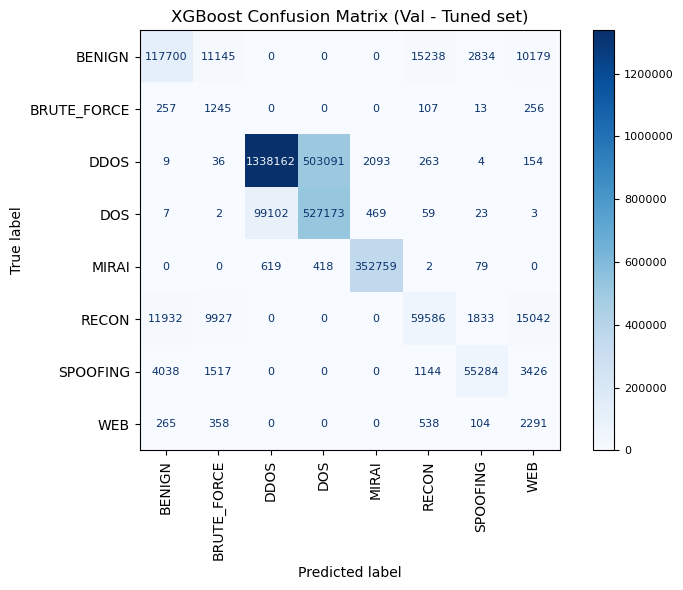


=== XGBOOST TEST - TUNED SET PERFORMANCE ===
Accuracy            : 0.7789
Precision (macro)   : 0.6410
Precision (weighted): 0.8451
Recall (macro)      : 0.7580
Recall (weighted)   : 0.7789
F1 (macro)          : 0.6301
F1 (weighted)       : 0.7955

XGBoost Classification Report (Test - Tuned):
              precision    recall  f1-score   support

      BENIGN     0.8778    0.7492    0.8084    157096
 BRUTE_FORCE     0.0517    0.6624    0.0959      1878
        DDOS     0.9309    0.7255    0.8155   1843812
         DOS     0.5114    0.8416    0.6362    626838
       MIRAI     0.9928    0.9969    0.9949    353878
       RECON     0.7729    0.6065    0.6796     98319
    SPOOFING     0.9180    0.8467    0.8809     65409
         WEB     0.0722    0.6353    0.1296      3556

    accuracy                         0.7789   3150786
   macro avg     0.6410    0.7580    0.6301   3150786
weighted avg     0.8451    0.7789    0.7955   3150786

Saved table to ..\Tables\XGBoost_Test - Tuned_Classif

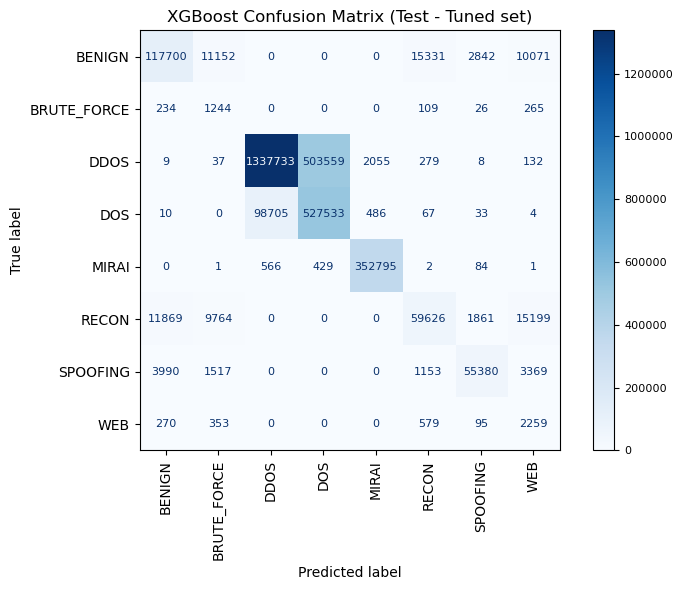

In [24]:
# helper function to evaluate validation and testing of XGBoost model
def evaluate_multiclass_model_xgboost(pipeline, X, y_true_enc, split_name="val"):
    """
    Evaluate a multiclass XGBoost classifier with accuracy, precision,
    recall, macro/weighted F1, classification report, and confusion matrix.
    """
    y_pred_enc = pipeline.predict(X)
    y_pred_proba = None
    if hasattr(pipeline.named_steps["model"], "predict_proba"):
        y_pred_proba = pipeline.predict_proba(X)

    # Basic metrics
    acc = accuracy_score(y_true_enc, y_pred_enc)
    f1_macro = f1_score(y_true_enc, y_pred_enc, average="macro")
    f1_weighted = f1_score(y_true_enc, y_pred_enc, average="weighted")

    precision_macro = precision_score(
        y_true_enc, y_pred_enc, average="macro", zero_division=0
    )
    precision_weighted = precision_score(
        y_true_enc, y_pred_enc, average="weighted", zero_division=0
    )

    recall_macro = recall_score(
        y_true_enc, y_pred_enc, average="macro", zero_division=0
    )
    recall_weighted = recall_score(
        y_true_enc, y_pred_enc, average="weighted", zero_division=0
    )

    print(f"\n=== XGBOOST {split_name.upper()} SET PERFORMANCE ===")
    print(f"Accuracy            : {acc:.4f}")
    print(f"Precision (macro)   : {precision_macro:.4f}")
    print(f"Precision (weighted): {precision_weighted:.4f}")
    print(f"Recall (macro)      : {recall_macro:.4f}")
    print(f"Recall (weighted)   : {recall_weighted:.4f}")
    print(f"F1 (macro)          : {f1_macro:.4f}")
    print(f"F1 (weighted)       : {f1_weighted:.4f}")

    # Classification report with readable class names
    report = classification_report(
        y_true_enc,
        y_pred_enc,
        target_names=class_names,
        digits=4
    )
    print(f"\nXGBoost Classification Report ({split_name}):")
    print(report)

    # Optionally save classification report as a table
    report_dict = metrics.classification_report(
        y_true_enc,
        y_pred_enc,
        target_names=class_names,
        output_dict=True
    )
    report_df = pd.DataFrame(report_dict).T
    save_table(report_df, f"XGBoost_{split_name}_Classification_Report.csv", index=True)

    # Confusion matrix
    cm = confusion_matrix(y_true_enc, y_pred_enc)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax, cmap="Blues", xticks_rotation=90, values_format='d', colorbar=False)

    # Make the numbers inside the cells smaller
    for txt in disp.text_.ravel():
        txt.set_fontsize(8)

    # Add a colorbar without scientific notation
    cbar = fig.colorbar(disp.im_, ax=ax, format="%.0f")
    cbar.ax.tick_params(labelsize=8)

    ax.set_title(f"XGBoost Confusion Matrix ({split_name} set)")
    plt.tight_layout()

    save_figure(fig, f"XGBoost_{split_name}_Confusion_Matrix.png", dpi=300)
    plt.show()
    plt.close(fig)

    # Return metrics in case we want to store them programmatically
    return {
        "accuracy": acc,
        "precision_macro": precision_macro,
        "precision_weighted": precision_weighted,
        "recall_macro": recall_macro,
        "recall_weighted": recall_weighted,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "y_pred_enc": y_pred_enc,
        "y_pred_proba": y_pred_proba,
    }


# Evaluate XGBoost on validation and test sets

xgb_val_results = evaluate_multiclass_model_xgboost(
    xgb_pipeline,
    X_val,
    y_val_enc,
    split_name="Val - Tuned"
)

xgb_test_results = evaluate_multiclass_model_xgboost(
    xgb_pipeline,
    X_test,
    y_test_enc,
    split_name="Test - Tuned"
)

## Logistic Regression Model

In [25]:
# Multiclass Logistic Regression model development

# for linear models we want scaled numeric features.
# build a dedicated preprocessor for Logistic Regression
numeric_transformer_lr = RobustScaler()
categorical_transformer_lr = OneHotEncoder(handle_unknown="ignore")

preprocessor_lr = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_lr, numeric_features),
        ("cat", categorical_transformer_lr, categorical_features),
    ]
)

# Define the Logistic Regression classifier
logreg_clf = LogisticRegression(
    multi_class="multinomial",
    solver="saga",
    penalty="l2",
    max_iter=1000,
    n_jobs=-1,
    random_state=RANDOM_SEED
)

# build the full modeling pipeline for Logistic Regression
logreg_pipeline = SKPipeline(
    steps=[
        ("preprocess", preprocessor_lr),
        ("model", logreg_clf),
    ]
)

# Cross-validation on the balanced training data (reuse the same cv object)
cv_results_logreg = cross_validate(
    logreg_pipeline,
    X_train_bal,
    y_train_bal_enc,
    cv=cv,
    scoring=[
        "accuracy",
        "f1_macro", "f1_weighted",
        "precision_macro", "precision_weighted",
        "recall_macro", "recall_weighted",
    ],
    n_jobs=-1,
    return_train_score=False
)

cv_logreg_df = pd.DataFrame(cv_results_logreg)
cv_logreg_summary = cv_logreg_df[
    [
        "test_accuracy",
        "test_f1_macro", "test_f1_weighted",
        "test_precision_macro", "test_precision_weighted",
        "test_recall_macro", "test_recall_weighted",
    ]
].agg(["mean", "std"]).T

cv_logreg_summary.columns = ["mean", "std"]

print("\nLogistic Regression Cross-validation performance (balanced training set):")
print(cv_logreg_summary)

# Optionally save CV results and summary for Logistic Regression
# save_table(cv_logreg_df, "LogisticRegression_CV_Results.csv", index=False)
# save_table(cv_logreg_summary, "LogisticRegression_CV_Summary.csv", index=True)

# Fit the Logistic Regression pipeline on the full balanced training set
logreg_pipeline.fit(X_train_bal, y_train_bal_enc)


Logistic Regression Cross-validation performance (balanced training set):
                             mean       std
test_accuracy            0.361750  0.056925
test_f1_macro            0.299249  0.072345
test_f1_weighted         0.299245  0.072332
test_precision_macro     0.327478  0.062506
test_precision_weighted  0.327475  0.062499
test_recall_macro        0.361755  0.056943
test_recall_weighted     0.361750  0.056925


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [26]:
# Hyperparameter tuning for Logistic Regression using RandomizedSearchCV
logreg_param_distributions = {
    "model__C": np.logspace(-3, 2, 10),   # 0.001 to 100 on a log scale
    # Keep solver and penalty aligned with base config
    "model__penalty": ["l2"],
    "model__solver": ["saga"],
    # explore larger max_iter for tougher fits
    "model__max_iter": [500, 1000, 2000],
}

logreg_random_search = RandomizedSearchCV(
    estimator=logreg_pipeline,
    param_distributions=logreg_param_distributions,
    n_iter=50,  # number of random combinations to try
    scoring={
        "accuracy": "accuracy",
        "f1_macro": "f1_macro",
        "f1_weighted": "f1_weighted",
    },
    refit="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=RANDOM_SEED,
    return_train_score=False,
)

# Fit the tuner on the balanced training set
logreg_random_search.fit(X_train_bal, y_train_bal_enc)

print("\nBest Logistic Regression parameters found (RandomizedSearchCV):")
print(logreg_random_search.best_params_)
print(f"\nBest CV f1_macro (tuned Logistic Regression): {logreg_random_search.best_score_:.4f}")

# Store and (optionally) save detailed CV results from the search
logreg_search_cv_df = pd.DataFrame(logreg_random_search.cv_results_)
# save_table(logreg_search_cv_df, "LogisticRegression_RandomSearch_CV_Results.csv", index=False)

# Get the tuned pipeline and overwrite logreg_pipeline so the rest of the code
# uses the best-found Logistic Regression model
logreg_best_pipeline = logreg_random_search.best_estimator_
logreg_pipeline = logreg_best_pipeline

Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best Logistic Regression parameters found (RandomizedSearchCV):
{'model__solver': 'saga', 'model__penalty': 'l2', 'model__max_iter': 2000, 'model__C': 0.003593813663804626}

Best CV f1_macro (tuned Logistic Regression): 0.3047



=== LOGISTIC REGRESSION VAL - TUNED SET PERFORMANCE ===
Accuracy            : 0.5523
Precision (macro)   : 0.3508
Precision (weighted): 0.6256
Recall (macro)      : 0.3449
Recall (weighted)   : 0.5523
F1 (macro)          : 0.2836
F1 (weighted)       : 0.5593

Logistic Regression Classification Report (Val - Tuned):
              precision    recall  f1-score   support

      BENIGN     0.3287    0.5154    0.4014    157096
 BRUTE_FORCE     0.0116    0.1502    0.0216      1878
        DDOS     0.7842    0.5584    0.6523   1843812
         DOS     0.3023    0.5009    0.3770    626838
       MIRAI     0.6138    0.8856    0.7250    353877
       RECON     0.5726    0.0132    0.0258     98320
    SPOOFING     0.1582    0.0057    0.0110     65409
         WEB     0.0347    0.1299    0.0548      3556

    accuracy                         0.5523   3150786
   macro avg     0.3508    0.3449    0.2836   3150786
weighted avg     0.6256    0.5523    0.5593   3150786

Saved table to ..\Tables\Logist

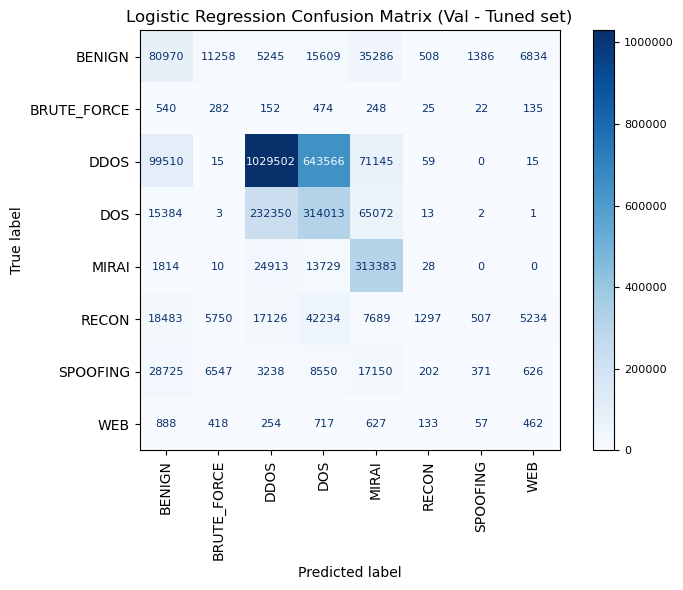


=== LOGISTIC REGRESSION TEST - TUNED SET PERFORMANCE ===
Accuracy            : 0.5520
Precision (macro)   : 0.3451
Precision (weighted): 0.6244
Recall (macro)      : 0.3428
Recall (weighted)   : 0.5520
F1 (macro)          : 0.2823
F1 (weighted)       : 0.5590

Logistic Regression Classification Report (Test - Tuned):
              precision    recall  f1-score   support

      BENIGN     0.3277    0.5130    0.3999    157096
 BRUTE_FORCE     0.0115    0.1491    0.0213      1878
        DDOS     0.7843    0.5580    0.6521   1843812
         DOS     0.3024    0.5014    0.3772    626838
       MIRAI     0.6131    0.8855    0.7245    353878
       RECON     0.5452    0.0120    0.0234     98319
    SPOOFING     0.1454    0.0053    0.0102     65409
         WEB     0.0313    0.1178    0.0495      3556

    accuracy                         0.5520   3150786
   macro avg     0.3451    0.3428    0.2823   3150786
weighted avg     0.6244    0.5520    0.5590   3150786

Saved table to ..\Tables\Logi

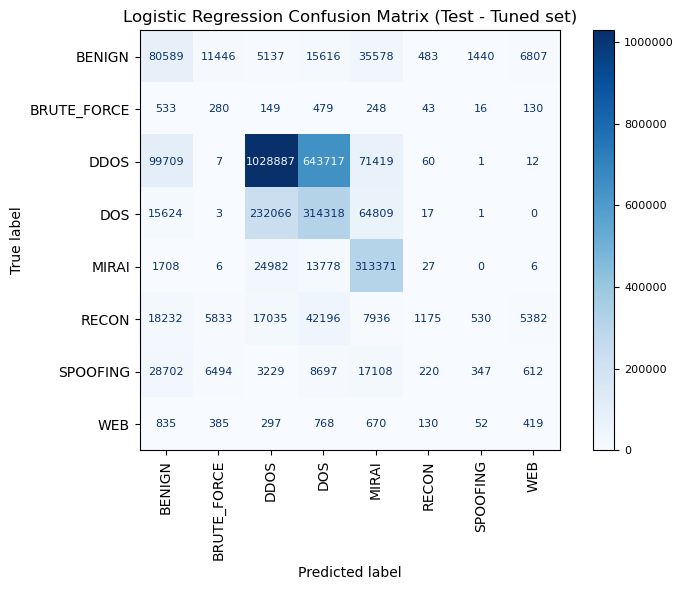

In [27]:
# Helper function to evaluate Logistic Regression on val/test
def evaluate_multiclass_model_logreg(pipeline, X, y_true_enc, split_name="val"):
    """
    Evaluate a multiclass Logistic Regression classifier with accuracy,
    precision, recall, macro/weighted F1, classification report,
    and confusion matrix.
    """
    y_pred_enc = pipeline.predict(X)
    y_pred_proba = None
    if hasattr(pipeline.named_steps["model"], "predict_proba"):
        y_pred_proba = pipeline.predict_proba(X)

    # Basic metrics
    acc = accuracy_score(y_true_enc, y_pred_enc)
    f1_macro = f1_score(y_true_enc, y_pred_enc, average="macro")
    f1_weighted = f1_score(y_true_enc, y_pred_enc, average="weighted")

    precision_macro = precision_score(
        y_true_enc, y_pred_enc, average="macro", zero_division=0
    )
    precision_weighted = precision_score(
        y_true_enc, y_pred_enc, average="weighted", zero_division=0
    )

    recall_macro = recall_score(
        y_true_enc, y_pred_enc, average="macro", zero_division=0
    )
    recall_weighted = recall_score(
        y_true_enc, y_pred_enc, average="weighted", zero_division=0
    )

    print(f"\n=== LOGISTIC REGRESSION {split_name.upper()} SET PERFORMANCE ===")
    print(f"Accuracy            : {acc:.4f}")
    print(f"Precision (macro)   : {precision_macro:.4f}")
    print(f"Precision (weighted): {precision_weighted:.4f}")
    print(f"Recall (macro)      : {recall_macro:.4f}")
    print(f"Recall (weighted)   : {recall_weighted:.4f}")
    print(f"F1 (macro)          : {f1_macro:.4f}")
    print(f"F1 (weighted)       : {f1_weighted:.4f}")

    # Classification report with readable class names
    report = classification_report(
        y_true_enc,
        y_pred_enc,
        target_names=class_names,
        digits=4
    )
    print(f"\nLogistic Regression Classification Report ({split_name}):")
    print(report)

    # Optionally save classification report as a table
    report_dict = metrics.classification_report(
        y_true_enc,
        y_pred_enc,
        target_names=class_names,
        output_dict=True
    )
    report_df = pd.DataFrame(report_dict).T
    save_table(report_df, f"LogisticRegression_{split_name}_Classification_Report.csv", index=True)

    # Confusion matrix
    cm = confusion_matrix(y_true_enc, y_pred_enc)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax, cmap="Blues", xticks_rotation=90, values_format='d', colorbar=False)

    # Make the numbers inside the cells smaller
    for txt in disp.text_.ravel():
        txt.set_fontsize(8)

    # Add a colorbar without scientific notation
    cbar = fig.colorbar(disp.im_, ax=ax, format="%.0f")
    cbar.ax.tick_params(labelsize=8)

    ax.set_title(f"Logistic Regression Confusion Matrix ({split_name} set)")
    plt.tight_layout()

    save_figure(fig, f"LogisticRegression_{split_name}_Confusion_Matrix.png", dpi=300)
    plt.show()
    plt.close(fig)

    # Return metrics in case we want to store them programmatically
    return {
        "accuracy": acc,
        "precision_macro": precision_macro,
        "precision_weighted": precision_weighted,
        "recall_macro": recall_macro,
        "recall_weighted": recall_weighted,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "y_pred_enc": y_pred_enc,
        "y_pred_proba": y_pred_proba,
    }

# Evaluate Logistic Regression on validation and test sets

logreg_val_results = evaluate_multiclass_model_logreg(
    logreg_pipeline,
    X_val,
    y_val_enc,
    split_name="Val - Tuned"
)

logreg_test_results = evaluate_multiclass_model_logreg(
    logreg_pipeline,
    X_test,
    y_test_enc,
    split_name="Test - Tuned"
)

## Linear SVM Model

In [28]:
# Multiclass Linear SVM (LinearSVC) model development

numeric_transformer_svm = RobustScaler()
categorical_transformer_svm = OneHotEncoder(handle_unknown="ignore")

preprocessor_svm = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_svm, numeric_features),
        ("cat", categorical_transformer_svm, categorical_features),
    ]
)

# Define the Linear SVM classifier (LinearSVC)
svm_clf = LinearSVC(
    C=1.0,
    multi_class="ovr",     # one-vs-rest for multiclass
    max_iter=5000,         # bump iterations to help convergence
    dual=False,            # prefer dual=False when n_samples > n_features
    random_state=RANDOM_SEED
)

# Build the full modeling pipeline for Linear SVM
svm_pipeline = SKPipeline(
    steps=[
        ("preprocess", preprocessor_svm),
        ("model", svm_clf),
    ]
)

# Cross-validation on the balanced training data (reuse the same cv object)
cv_results_svm = cross_validate(
    svm_pipeline,
    X_train_bal,
    y_train_bal_enc,
    cv=cv,
    scoring=[
        "accuracy",
        "f1_macro", "f1_weighted",
        "precision_macro", "precision_weighted",
        "recall_macro", "recall_weighted",
    ],
    n_jobs=-1,
    return_train_score=False
)

cv_svm_df = pd.DataFrame(cv_results_svm)
cv_svm_summary = cv_svm_df[
    [
        "test_accuracy",
        "test_f1_macro", "test_f1_weighted",
        "test_precision_macro", "test_precision_weighted",
        "test_recall_macro", "test_recall_weighted",
    ]
].agg(["mean", "std"]).T

cv_svm_summary.columns = ["mean", "std"]

print("\nLinear SVM (LinearSVC) Cross-validation performance (balanced training set):")
print(cv_svm_summary)

# Optionally save CV results and summary for Linear SVM
# save_table(cv_svm_df, "LinearSVM_CV_Results.csv", index=False)
# save_table(cv_svm_summary, "LinearSVM_CV_Summary.csv", index=True)

# Fit the Linear SVM pipeline on the full balanced training set
svm_pipeline.fit(X_train_bal, y_train_bal_enc)


Linear SVM (LinearSVC) Cross-validation performance (balanced training set):
                             mean       std
test_accuracy            0.612249  0.001374
test_f1_macro            0.611128  0.000873
test_f1_weighted         0.611128  0.000882
test_precision_macro     0.639933  0.003196
test_precision_weighted  0.639933  0.003209
test_recall_macro        0.612249  0.001360
test_recall_weighted     0.612249  0.001374


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [29]:
# Hyperparameter tuning for Linear SVM (LinearSVC) using RandomizedSearchCV
svm_param_distributions = {
    # Inverse regularization strength: smaller C => stronger regularization
    "model__C": np.logspace(-3, 2, 10),   # 0.001 to 100 on a log scale
    # Allow the optimizer to take more steps if needed
    "model__max_iter": [3000, 5000, 8000, 10000],
    # Convergence tolerance
    "model__tol": [1e-4, 1e-3, 1e-2],
}

svm_random_search = RandomizedSearchCV(
    estimator=svm_pipeline,
    param_distributions=svm_param_distributions,
    n_iter=50,  # number of random combinations to try
    scoring={
        "accuracy": "accuracy",
        "f1_macro": "f1_macro",
        "f1_weighted": "f1_weighted",
    },
    refit="f1_macro",
    cv=cv,              # same StratifiedKFold as other models
    n_jobs=-1,
    verbose=2,
    random_state=RANDOM_SEED,
    return_train_score=False,
)

# Fit the tuner on the balanced training set
svm_random_search.fit(X_train_bal, y_train_bal_enc)

print("\nBest Linear SVM (LinearSVC) parameters found (RandomizedSearchCV):")
print(svm_random_search.best_params_)
print(f"\nBest CV f1_macro (tuned Linear SVM): {svm_random_search.best_score_:.4f}")

# Store and (optionally) save detailed CV results from the search
svm_search_cv_df = pd.DataFrame(svm_random_search.cv_results_)
# save_table(svm_search_cv_df, "LinearSVM_RandomSearch_CV_Results.csv", index=False)

# Get the tuned pipeline and overwrite svm_pipeline so the rest of the code
# uses the best-found Linear SVM model
svm_best_pipeline = svm_random_search.best_estimator_
svm_pipeline = svm_best_pipeline

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best Linear SVM (LinearSVC) parameters found (RandomizedSearchCV):
{'model__tol': 0.0001, 'model__max_iter': 10000, 'model__C': 2.1544346900318843}

Best CV f1_macro (tuned Linear SVM): 0.6115



=== LINEAR SVM VAL SET PERFORMANCE ===
Accuracy            : 0.7051
Precision (macro)   : 0.5517
Precision (weighted): 0.8189
Recall (macro)      : 0.6157
Recall (weighted)   : 0.7051
F1 (macro)          : 0.5283
F1 (weighted)       : 0.7265

Linear SVM Classification Report (Val):
              precision    recall  f1-score   support

      BENIGN     0.7739    0.5497    0.6428    157096
 BRUTE_FORCE     0.0640    0.3514    0.1083      1878
        DDOS     0.9373    0.6209    0.7470   1843812
         DOS     0.4411    0.8782    0.5873    626838
       MIRAI     0.9947    0.9894    0.9921    353877
       RECON     0.7558    0.5015    0.6029     98320
    SPOOFING     0.4152    0.5869    0.4864     65409
         WEB     0.0318    0.4474    0.0595      3556

    accuracy                         0.7051   3150786
   macro avg     0.5517    0.6157    0.5283   3150786
weighted avg     0.8189    0.7051    0.7265   3150786

Saved table to ..\Tables\LinearSVM_Val_Classification_Report.csv


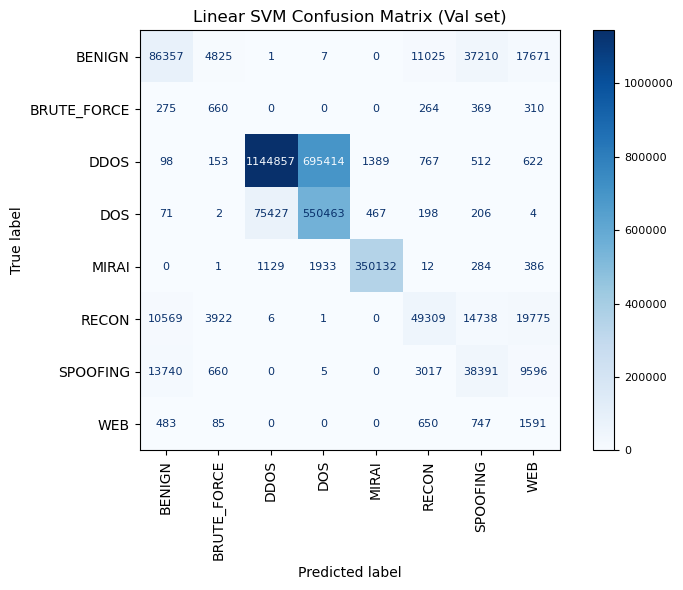


=== LINEAR SVM TEST SET PERFORMANCE ===
Accuracy            : 0.7054
Precision (macro)   : 0.5517
Precision (weighted): 0.8193
Recall (macro)      : 0.6127
Recall (weighted)   : 0.7054
F1 (macro)          : 0.5278
F1 (weighted)       : 0.7268

Linear SVM Classification Report (Test):
              precision    recall  f1-score   support

      BENIGN     0.7766    0.5500    0.6440    157096
 BRUTE_FORCE     0.0625    0.3466    0.1059      1878
        DDOS     0.9378    0.6211    0.7473   1843812
         DOS     0.4415    0.8791    0.5878    626838
       MIRAI     0.9948    0.9897    0.9922    353878
       RECON     0.7546    0.4998    0.6013     98319
    SPOOFING     0.4152    0.5886    0.4869     65409
         WEB     0.0303    0.4266    0.0566      3556

    accuracy                         0.7054   3150786
   macro avg     0.5517    0.6127    0.5278   3150786
weighted avg     0.8193    0.7054    0.7268   3150786

Saved table to ..\Tables\LinearSVM_Test_Classification_Report.c

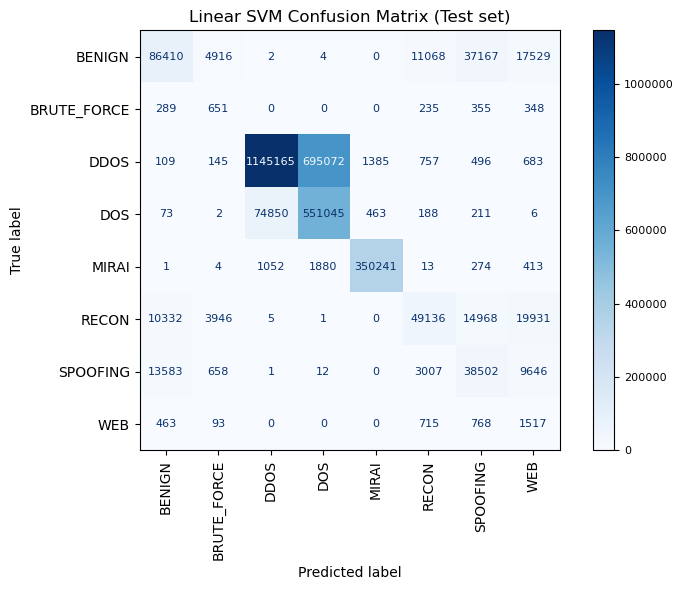

In [30]:
# Helper function to evaluate Linear SVM on val/test
def evaluate_multiclass_model_linearsvm(pipeline, X, y_true_enc, split_name="val"):
    """
    Evaluate a multiclass Linear SVM (LinearSVC) classifier with accuracy,
    precision, recall, macro/weighted F1, classification report,
    and confusion matrix.
    """
    y_pred_enc = pipeline.predict(X)

    # LinearSVC does not implement predict_proba; we keep this for API consistency
    y_pred_proba = None
    if hasattr(pipeline.named_steps["model"], "predict_proba"):
        y_pred_proba = pipeline.predict_proba(X)

    # Basic metrics
    acc = accuracy_score(y_true_enc, y_pred_enc)
    f1_macro = f1_score(y_true_enc, y_pred_enc, average="macro")
    f1_weighted = f1_score(y_true_enc, y_pred_enc, average="weighted")

    precision_macro = precision_score(
        y_true_enc, y_pred_enc, average="macro", zero_division=0
    )
    precision_weighted = precision_score(
        y_true_enc, y_pred_enc, average="weighted", zero_division=0
    )

    recall_macro = recall_score(
        y_true_enc, y_pred_enc, average="macro", zero_division=0
    )
    recall_weighted = recall_score(
        y_true_enc, y_pred_enc, average="weighted", zero_division=0
    )

    print(f"\n=== LINEAR SVM {split_name.upper()} SET PERFORMANCE ===")
    print(f"Accuracy            : {acc:.4f}")
    print(f"Precision (macro)   : {precision_macro:.4f}")
    print(f"Precision (weighted): {precision_weighted:.4f}")
    print(f"Recall (macro)      : {recall_macro:.4f}")
    print(f"Recall (weighted)   : {recall_weighted:.4f}")
    print(f"F1 (macro)          : {f1_macro:.4f}")
    print(f"F1 (weighted)       : {f1_weighted:.4f}")

    # Classification report with readable class names
    report = classification_report(
        y_true_enc,
        y_pred_enc,
        target_names=class_names,
        digits=4
    )
    print(f"\nLinear SVM Classification Report ({split_name}):")
    print(report)

    # Optionally save classification report as a table
    report_dict = metrics.classification_report(
        y_true_enc,
        y_pred_enc,
        target_names=class_names,
        output_dict=True
    )
    report_df = pd.DataFrame(report_dict).T
    save_table(report_df, f"LinearSVM_{split_name}_Classification_Report.csv", index=True)

    # Confusion matrix
    cm = confusion_matrix(y_true_enc, y_pred_enc)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax, cmap="Blues", xticks_rotation=90, values_format='d', colorbar=False)

    # Make the numbers inside the cells smaller
    for txt in disp.text_.ravel():
        txt.set_fontsize(8)

    # Add a colorbar without scientific notation
    cbar = fig.colorbar(disp.im_, ax=ax, format="%.0f")
    cbar.ax.tick_params(labelsize=8)

    ax.set_title(f"Linear SVM Confusion Matrix ({split_name} set)")
    plt.tight_layout()

    save_figure(fig, f"LinearSVM_{split_name}_Confusion_Matrix.png", dpi=300)
    plt.show()
    plt.close(fig)

    # Return metrics in case we want to store them programmatically
    return {
        "accuracy": acc,
        "precision_macro": precision_macro,
        "precision_weighted": precision_weighted,
        "recall_macro": recall_macro,
        "recall_weighted": recall_weighted,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "y_pred_enc": y_pred_enc,
        "y_pred_proba": y_pred_proba,
    }


# Evaluate Linear SVM on validation and test sets

svm_val_results = evaluate_multiclass_model_linearsvm(
    svm_pipeline,
    X_val,
    y_val_enc,
    split_name="Val"
)

svm_test_results = evaluate_multiclass_model_linearsvm(
    svm_pipeline,
    X_test,
    y_test_enc,
    split_name="Test"
)

## CNN Model

In [ ]:
# Deep learning / CNN imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    InputLayer,
    Conv1D,
    GlobalMaxPooling1D,
    Dense,
    Dropout,
    BatchNormalization,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

tf.random.set_seed(RANDOM_SEED)


In [ ]:
# Preprocessing for CNN (full imbalanced train set)
numeric_transformer_cnn = RobustScaler()

# If you are on an older sklearn (<1.2), change sparse_output=False -> sparse=False
categorical_transformer_cnn = OneHotEncoder(
    handle_unknown="ignore",
    sparse_output=False
)

preprocessor_cnn = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_cnn, numeric_features),
        ("cat", categorical_transformer_cnn, categorical_features),
    ]
)

# Fit on the FULL (imbalanced) training data
X_train_full_proc = preprocessor_cnn.fit_transform(X_train_full)
X_val_proc = preprocessor_cnn.transform(X_val)
X_test_proc = preprocessor_cnn.transform(X_test)

# Ensure dense arrays in case anything is still sparse
if hasattr(X_train_full_proc, "toarray"):
    X_train_full_proc = X_train_full_proc.toarray()
    X_val_proc = X_val_proc.toarray()
    X_test_proc = X_test_proc.toarray()

# Reshape for 1D CNN: (n_samples, n_features, 1)
n_features_cnn = X_train_full_proc.shape[1]

X_train_cnn = X_train_full_proc.reshape(-1, n_features_cnn, 1)
X_val_cnn = X_val_proc.reshape(-1, n_features_cnn, 1)
X_test_cnn = X_test_proc.reshape(-1, n_features_cnn, 1)

print(f"1D CNN input shape (train): {X_train_cnn.shape}, n_classes: {n_classes}")

# ---------- Encode labels for full training set ----------

# label_encoder was already fit earlier on y_train_bal, which includes all classes
y_train_full_enc = label_encoder.transform(y_train_full)
# y_val_enc and y_test_enc already exist

# ---------- Compute class weights on FULL training distribution ----------

classes = np.unique(y_train_full_enc)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train_full_enc
)
class_weight_dict = {cls: w for cls, w in zip(classes, class_weights)}
print("Class weights:", class_weight_dict)

# ---------- CNN model definition ----------

def build_cnn_model(input_shape, n_classes, learning_rate=1e-3):
    """
    Build a simple 1D CNN for multiclass classification on tabular data.
    """
    model = Sequential([
        InputLayer(input_shape=input_shape),

        Conv1D(filters=64, kernel_size=3, activation="relu", padding="same"),
        BatchNormalization(),

        Conv1D(filters=64, kernel_size=3, activation="relu", padding="same"),
        GlobalMaxPooling1D(),

        Dropout(0.5),
        Dense(128, activation="relu"),
        Dropout(0.5),

        Dense(n_classes, activation="softmax")
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",  # integer labels
        metrics=["accuracy"],
    )

    return model

cnn_input_shape = (n_features_cnn, 1)
cnn_model_full = build_cnn_model(
    input_shape=cnn_input_shape,
    n_classes=n_classes,
    learning_rate=1e-3
)

cnn_model_full.summary()

# ---------- Training with Early Stopping and Class Weights ----------

early_stopping_cnn = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1
)

cnn_history_full = cnn_model_full.fit(
    X_train_cnn,
    y_train_full_enc,
    validation_data=(X_val_cnn, y_val_enc),
    epochs=20,
    batch_size=1024,
    callbacks=[early_stopping_cnn],
    class_weight=class_weight_dict,
    verbose=1
)

In [ ]:
# Evaluation helpers for the CNN
def evaluate_multiclass_model_cnn(model, X_cnn, y_true_enc, split_name="val"):
    """
    Evaluate the 1D CNN multiclass classifier with accuracy, precision, recall,
    macro/weighted F1, classification report, and confusion matrix.
    """
    # Predict probabilities then convert to class indices
    y_pred_proba = model.predict(X_cnn)
    y_pred_enc = np.argmax(y_pred_proba, axis=1)

    # Basic metrics
    acc = accuracy_score(y_true_enc, y_pred_enc)
    f1_macro = f1_score(y_true_enc, y_pred_enc, average="macro")
    f1_weighted = f1_score(y_true_enc, y_pred_enc, average="weighted")

    precision_macro = precision_score(
        y_true_enc, y_pred_enc, average="macro", zero_division=0
    )
    precision_weighted = precision_score(
        y_true_enc, y_pred_enc, average="weighted", zero_division=0
    )

    recall_macro = recall_score(
        y_true_enc, y_pred_enc, average="macro", zero_division=0
    )
    recall_weighted = recall_score(
        y_true_enc, y_pred_enc, average="weighted", zero_division=0
    )

    print(f"\n=== CNN {split_name.upper()} SET PERFORMANCE ===")
    print(f"Accuracy            : {acc:.4f}")
    print(f"Precision (macro)   : {precision_macro:.4f}")
    print(f"Precision (weighted): {precision_weighted:.4f}")
    print(f"Recall (macro)      : {recall_macro:.4f}")
    print(f"Recall (weighted)   : {recall_weighted:.4f}")
    print(f"F1 (macro)          : {f1_macro:.4f}")
    print(f"F1 (weighted)       : {f1_weighted:.4f}")

    # Classification report with readable class names
    report = classification_report(
        y_true_enc,
        y_pred_enc,
        target_names=class_names,
        digits=4
    )
    print(f"\nCNN Classification Report ({split_name}):")
    print(report)

    # Optionally save classification report as a table
    report_dict = metrics.classification_report(
        y_true_enc,
        y_pred_enc,
        target_names=class_names,
        output_dict=True
    )
    report_df = pd.DataFrame(report_dict).T
    # save_table(report_df, f"CNN_{split_name}_Classification_Report.csv", index=True)

    # Confusion matrix
    cm = confusion_matrix(y_true_enc, y_pred_enc)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax, cmap="Blues", xticks_rotation=90, values_format='d', colorbar=False)

    # Make the numbers inside the cells smaller
    for txt in disp.text_.ravel():
        txt.set_fontsize(8)

    # Add a colorbar without scientific notation
    cbar = fig.colorbar(disp.im_, ax=ax, format="%.0f")
    cbar.ax.tick_params(labelsize=8)

    ax.set_title(f"CNN Confusion Matrix ({split_name} set)")
    plt.tight_layout()

    # save_figure(fig, f"CNN_{split_name}_Confusion_Matrix.png", dpi=300)
    plt.show()
    plt.close(fig)

    return {
        "accuracy": acc,
        "precision_macro": precision_macro,
        "precision_weighted": precision_weighted,
        "recall_macro": recall_macro,
        "recall_weighted": recall_weighted,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "y_pred_enc": y_pred_enc,
        "y_pred_proba": y_pred_proba,
    }

# ---------- Evaluate CNN on validation and test sets ----------

cnn_val_results_full = evaluate_multiclass_model_cnn(
    cnn_model_full,
    X_val_cnn,
    y_val_enc,
    split_name="Val-Full"
)

cnn_test_results_full = evaluate_multiclass_model_cnn(
    cnn_model_full,
    X_test_cnn,
    y_test_enc,
    split_name="Test-Full"
)


## LSTM Model

In [ ]:
from tensorflow.keras.layers import LSTM

In [ ]:
X_train_lstm = X_train_cnn
X_val_lstm = X_val_cnn
X_test_lstm = X_test_cnn

print(f"LSTM input shape (train): {X_train_lstm.shape}, n_classes: {n_classes}")

# LSTM model definition

def build_lstm_model(input_shape, n_classes, learning_rate=1e-3):
    """
    Build an LSTM-based RNN for multiclass classification on tabular data.
    Each feature is treated as a timestep with 1 feature channel.
    """
    model = Sequential([
        InputLayer(input_shape=input_shape),

        # First recurrent layer, returns full sequence to feed into second LSTM
        LSTM(64, return_sequences=True),
        BatchNormalization(),

        # Second recurrent layer, returns final hidden state
        LSTM(64),

        Dropout(0.5),
        Dense(128, activation="relu"),
        Dropout(0.5),

        Dense(n_classes, activation="softmax")
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",  # integer-encoded labels
        metrics=["accuracy"],
    )

    return model

lstm_input_shape = (n_features_cnn, 1)
lstm_model_full = build_lstm_model(
    input_shape=lstm_input_shape,
    n_classes=n_classes,
    learning_rate=1e-3
)

lstm_model_full.summary()

# ---------- Training with Early Stopping and Class Weights ----------

early_stopping_lstm = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1
)

lstm_history_full = lstm_model_full.fit(
    X_train_lstm,
    y_train_full_enc,
    validation_data=(X_val_lstm, y_val_enc),
    epochs=20,
    batch_size=1024,
    callbacks=[early_stopping_lstm],
    class_weight=class_weight_dict,  # same class weights as CNN
    verbose=1
)

In [ ]:
def evaluate_multiclass_model_lstm(model, X_lstm, y_true_enc, split_name="val"):
    """
    Evaluate the LSTM-based RNN multiclass classifier with accuracy, precision,
    recall, macro/weighted F1, classification report, and confusion matrix.
    """
    # Predict probabilities then convert to class indices
    y_pred_proba = model.predict(X_lstm)
    y_pred_enc = np.argmax(y_pred_proba, axis=1)

    # Basic metrics
    acc = accuracy_score(y_true_enc, y_pred_enc)
    f1_macro = f1_score(y_true_enc, y_pred_enc, average="macro")
    f1_weighted = f1_score(y_true_enc, y_pred_enc, average="weighted")

    precision_macro = precision_score(
        y_true_enc, y_pred_enc, average="macro", zero_division=0
    )
    precision_weighted = precision_score(
        y_true_enc, y_pred_enc, average="weighted", zero_division=0
    )

    recall_macro = recall_score(
        y_true_enc, y_pred_enc, average="macro", zero_division=0
    )
    recall_weighted = recall_score(
        y_true_enc, y_pred_enc, average="weighted", zero_division=0
    )

    print(f"\n=== LSTM {split_name.upper()} SET PERFORMANCE ===")
    print(f"Accuracy            : {acc:.4f}")
    print(f"Precision (macro)   : {precision_macro:.4f}")
    print(f"Precision (weighted): {precision_weighted:.4f}")
    print(f"Recall (macro)      : {recall_macro:.4f}")
    print(f"Recall (weighted)   : {recall_weighted:.4f}")
    print(f"F1 (macro)          : {f1_macro:.4f}")
    print(f"F1 (weighted)       : {f1_weighted:.4f}")

    # Classification report with readable class names
    report = classification_report(
        y_true_enc,
        y_pred_enc,
        target_names=class_names,
        digits=4
    )
    print(f"\nLSTM Classification Report ({split_name}):")
    print(report)

    # Optionally save classification report as a table
    report_dict = metrics.classification_report(
        y_true_enc,
        y_pred_enc,
        target_names=class_names,
        output_dict=True
    )
    report_df = pd.DataFrame(report_dict).T
    # save_table(report_df, f"LSTM_{split_name}_Classification_Report.csv", index=True)

    # Confusion matrix
    cm = confusion_matrix(y_true_enc, y_pred_enc)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax, cmap="Blues", xticks_rotation=90, values_format='d', colorbar=False)

    # Make the numbers inside the cells smaller
    for txt in disp.text_.ravel():
        txt.set_fontsize(8)

    # Add a colorbar without scientific notation
    cbar = fig.colorbar(disp.im_, ax=ax, format="%.0f")
    cbar.ax.tick_params(labelsize=8)

    ax.set_title(f"LSTM Confusion Matrix ({split_name} set)")
    plt.tight_layout()

    # save_figure(fig, f"LSTM_{split_name}_Confusion_Matrix.png", dpi=300)
    plt.show()
    plt.close(fig)

    return {
        "accuracy": acc,
        "precision_macro": precision_macro,
        "precision_weighted": precision_weighted,
        "recall_macro": recall_macro,
        "recall_weighted": recall_weighted,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "y_pred_enc": y_pred_enc,
        "y_pred_proba": y_pred_proba,
    }

# ---------- Evaluate RNN on validation and test sets ----------

lstm_val_results_full = evaluate_multiclass_model_lstm(
    lstm_model_full,
    X_val_lstm,
    y_val_enc,
    split_name="Val-Full"
)

lstm_test_results_full = evaluate_multiclass_model_lstm(
    lstm_model_full,
    X_test_lstm,
    y_test_enc,
    split_name="Test-Full"
)